In [1]:
# %load_ext autoreload
import importlib
import pandas as pd
import os
import sys
import pwd
import numpy as np
from pathlib import Path
from tqdm import tqdm, trange
from tqdm.contrib.concurrent import process_map
import matplotlib.pyplot as plt
import GEOparse
import scanpy as sc
from scipy import sparse as sp
import sparse as spa
import scipy as spy
from scipy.stats import linregress, entropy
sys.path.append('../')
from meth import tools as mtools
from meth import analytic_tools as anatools
from meth.meth_anndata import AnnDataSet
from scipy.stats import pearsonr 

%load_ext autoreload
%autoreload 2
plt.style.use('../Stochastic aging/pics/meth.mplstyle')

In [2]:
cwd = Path.cwd()
cwd_base = Path('/Users/tarkhov/Dropbox/Harvard/Science/')
#project_dir = Path.joinpath(cwd, Path('data/GSE121436/'))
cwd_bulk = Path('/Users/tarkhov/Dropbox/Harvard/Science/Stochastic aging/')
#project_dir = Path.joinpath(cwd_bulk, Path('data/GSE121436/'))

dsets = {}
coverage = 0 
binned_by = 10

# dump_key="thresh_5_common_cpgs"
# dump_key="thresh_5_common_cpgs_only_coreg_and_stochastic_dynamics"
# dump_key="thresh_5_common_cpgsthresh_5_common_cpgs_only_coreg_and_stochastic_dynamics"
# dump_key=""
# dump_key='threshold_45'
dump_key='threshold_25'

paths = {
        'scMiceMuscle': Path.joinpath(cwd, Path(f'data/GSE121690/GSE121690_wmeta{dump_key}.h5ad')), #mm10
         'scBulkedMiceMuscle': Path.joinpath(cwd, Path(f'data/GSE121690/GSE121690_bulked_wmeta_mm10{dump_key}.h5ad')), 
        }


In [3]:
all_dsets = AnnDataSet(paths=paths)

Genes before 44711, and after merging scMiceMuscle: 44711
Genes before 44711, and after merging scBulkedMiceMuscle: 44711
Common genes number: 44711


In [4]:
all_dsets.update_dsets_view("full", "common_cpgs")

In [5]:

key_sc = 'scMiceMuscle'
key_bu = 'scBulkedMiceMuscle'
key_sc_bu = 'scBulkedMiceMuscle'

idx_per = np.arange(0, all_dsets.dsets_red[key_sc].X.shape[0], 2).astype(int)
idx_cov = np.arange(1, all_dsets.dsets_red[key_sc].X.shape[0], 2).astype(int)

X = all_dsets.dsets_red[key_sc].X[idx_per,:]
Xcov = all_dsets.dsets_red[key_sc].X[idx_cov,:]
print(X.shape)
n_cover = np.sum(Xcov > 0.5, axis=0)
n_cover = np.array(n_cover).flatten()
sum_cov = np.sum(Xcov, axis=0)
cover = sum_cov / n_cover

th = 15.
# th = 0.5
# print(np.sum(cover >= th), np.sum(cover < th))
print(np.sum(n_cover >= th), np.sum(n_cover < th))

(758, 44711)
44711 0


In [6]:
th = 25.
all_dsets.update_dsets_view("full", "common_cpgs")
idx_you = all_dsets.dsets_red[key_sc].obs['Age'].values * 365 /12 < 5
idx_you = idx_you[::2]

idx_mid_1 = np.logical_and(all_dsets.dsets_red[key_sc].obs['Age'].values * 365 /12 > 5, all_dsets.dsets_red[key_sc].obs['Age'].values * 365 /12 < 6)
idx_mid_1 = idx_mid_1[::2]

idx_mid = np.logical_and(all_dsets.dsets_red[key_sc].obs['Age'].values * 365 /12 > 6, all_dsets.dsets_red[key_sc].obs['Age'].values * 365 /12 < 7)
idx_mid = idx_mid[::2]

idx_old = all_dsets.dsets_red[key_sc].obs['Age'].values * 365 /12 > 7
idx_old = idx_old[::2]

n_cover_you = np.sum(Xcov[idx_you,:] > 0.5, axis=0)
n_cover_mid_1 = np.sum(Xcov[idx_mid_1,:] > 0.5, axis=0)
n_cover_mid = np.sum(Xcov[idx_mid,:] > 0.5, axis=0)
n_cover_old = np.sum(Xcov[idx_old,:] > 0.5, axis=0)
print(np.sum(np.logical_and(np.logical_and(n_cover_you >= th, n_cover_old >=th), n_cover_mid >=th)))#, np.sum(~np.logical_and(n_cover_you >= th, n_cover_old >=th)))

44711


In [7]:
all_dsets.chosen_genes.shape, np.logical_and(n_cover_you >= th, n_cover_old >=th).shape

((44711,), (1, 44711))

In [8]:

# idx_chosen = np.array(np.logical_and(n_cover_you >= th, n_cover_old >=th)).flatten()
idx_chosen = np.array(np.logical_and(np.logical_and(n_cover_you >= th, n_cover_old >=th), np.logical_and(n_cover_mid_1 >=th, n_cover_mid >=th))).flatten()
print(np.sum(idx_chosen), np.sum(~idx_chosen))
mask_cpgs = all_dsets.chosen_genes[idx_chosen]
print(mask_cpgs.shape)

44711 0
(44711,)


In [9]:
all_dsets.add_var_mask(var_mask=mask_cpgs, var_mask_name="cov>30cells")
all_dsets.update_dsets_view("full", "cov>30cells")
# all_dsets.dump_datasets(dump_key="threshold_25")

In [10]:
for association in ['meth']:
    all_dsets.find_aging_associations(#source_dsets=['Mice'], target_dsets=['Mice'], 
                                  #source_dsets=['scMiceMuscle'], 
                                  obs_mask_name='full', 
                                  # var_mask_name="prc2",
                                  var_mask_name="cov>30cells",
                                  #'common_cpgs', 
                                  association_name=association)

/Users/tarkhov/Dropbox/Harvard/Science/scDNAm/../meth/meth_anndata.py:192: RuntimeWarning: invalid value encountered in true_divide
  ba = ((1. * (ycov[:,idx] > 0.5)).multiply(b[:,idx]).multiply(y[:,idx]).sum(axis=1) - (1. * (ycov[:,idx] > 0.5)).multiply(x0[:,idx]).multiply(b[:,idx]).sum(axis=1)) / rescale_for_nans


In [11]:
all_dsets.update_dsets_view('full', 'cov>30cells')
# all_dsets.update_dsets_view('full', 'common_cpgs')
print(all_dsets.chosen_genes)

Index(['chr10_10017752', 'chr10_10024910', 'chr10_10025310', 'chr10_100741121',
       'chr10_100741132', 'chr10_100822792', 'chr10_100822855',
       'chr10_100913982', 'chr10_10108772', 'chr10_101182552',
       ...
       'chrY_90812178', 'chrY_90812240', 'chrY_90812266', 'chrY_90812272',
       'chrY_90812328', 'chrY_90812480', 'chrY_90825395', 'chrY_90825431',
       'chrY_9820738', 'chrY_9820776'],
      dtype='object', name='index', length=44711)


In [12]:

idx_per = np.arange(0, all_dsets.dsets_red[key_sc].X.shape[0], 2).astype(int)
idx_cov = np.arange(1, all_dsets.dsets_red[key_sc].X.shape[0], 2).astype(int)
x = all_dsets.dsets[key_sc].obs.iloc[idx_per, :]['Mouse_ID']

X = all_dsets.dsets_red[key_sc].X[idx_per,:].toarray()
Xcov = all_dsets.dsets_red[key_sc].X[idx_cov,:].toarray()

Index(['E4.5', 'E5.5', 'E6.5', 'E7.5'], dtype='object')


# Plot with programmed stochastic changes

In [27]:
all_dsets.update_dsets_view('full', 'cov>30cells')

In [28]:
xsc = all_dsets.dsets_red[f'{key_sc}'].var[f'b_{key_sc}_full_cov>30cells_meth_sign'].abs() > 0.01

In [29]:
# xbulk = all_dsets.dsets_red[f'{key_sc_bu}'].var[f'b_{key_sc_bu}_full_cov>30cells_meth_Bonf_sign'] > 0.01
xbulk = all_dsets.dsets_red[f'{key_sc_bu}'].var[f'b_{key_sc_bu}_full_cov>30cells_meth_sign'].abs() > 0.01
print(xsc, xbulk)
print(xsc.sum(), xbulk.sum())

index
chr10_10017752      True
chr10_10024910      True
chr10_10025310      True
chr10_100741121    False
chr10_100741132     True
                   ...  
chrY_90812480       True
chrY_90825395       True
chrY_90825431       True
chrY_9820738        True
chrY_9820776        True
Name: b_scMiceMuscle_full_cov>30cells_meth_sign, Length: 44711, dtype: bool index
chr10_10017752      True
chr10_10024910     False
chr10_10025310     False
chr10_100741121    False
chr10_100741132     True
                   ...  
chrY_90812480      False
chrY_90825395      False
chrY_90825431      False
chrY_9820738        True
chrY_9820776        True
Name: b_scBulkedMiceMuscle_full_cov>30cells_meth_sign, Length: 44711, dtype: bool
34883 6245


In [31]:
idx_s_nz = np.nonzero(np.logical_and(xsc.values, xbulk.values))[0]

In [32]:
len(idx_s_nz)

6000

In [33]:
all_dsets.update_dsets_view("full", "cov>30cells")

In [34]:
dset_base = key_sc_bu#'scMice'
age_filt = 'full'
cpg_filt = "cov>30cells"
#cpg_filt = 'common_cpgs'
data_trans = 'meth'

bioage = f'{dset_base}_{age_filt}_{cpg_filt}_{data_trans}'             

b_nonsign = all_dsets.dsets_red[f'{key_sc}'].var[f"r_{bioage}"].values
b_sign = all_dsets.dsets_red[f'{key_sc}'].var[f"r_{bioage}"].values

N_select = np.min([100000, len(idx_s_nz)])

np.random.shuffle(idx_s_nz)
irandom = idx_s_nz[:N_select]
b_s = np.zeros_like(b_sign)
b_s[irandom]= b_sign[irandom]

idx_ns_nz = np.nonzero(np.abs(b_nonsign) < 0.05)[0]
np.random.shuffle(idx_ns_nz)
irandom2 = idx_ns_nz[:N_select]
b_ns = np.zeros_like(b_nonsign)
b_ns[irandom2]= b_nonsign[irandom2]

In [35]:
idx_s = irandom
idx_ns = irandom2
idx_sel = np.hstack((idx_s, idx_ns)).flatten()
cpg_up = all_dsets.dsets_red[f'{key_sc}'].var.index[idx_s]
cpg_down = all_dsets.dsets_red[f'{key_sc}'].var.index[idx_ns]
print(cpg_up.shape, cpg_down.shape)

(6000,) (395,)


In [36]:
all_dsets.add_var_mask(var_mask=all_dsets.dsets_red[f'{key_sc}'].var.index[idx_sel].tolist(), var_mask_name="cov>30cells_1000clockx1000random")
all_dsets.update_dsets_view("full", "cov>30cells_1000clockx1000random")

In [37]:
all_dsets.update_dsets_view("full", "cov>30cells_1000clockx1000random")
idx_per = np.arange(0, all_dsets.dsets_red[f'{key_sc}'].X.shape[0], 2).astype(int)
idx_cov = np.arange(1, all_dsets.dsets_red[f'{key_sc}'].X.shape[0], 2).astype(int)
X = all_dsets.dsets_red[f'{key_sc}'].X[idx_per,:]
Xcov = all_dsets.dsets_red[f'{key_sc}'].X[idx_cov,:]
t = all_dsets.dsets_red[f'{key_sc}'].obs['Age'].values[::2]

In [38]:
np.savez('chosen_E55toE75_cpgs.npz', cpgs = all_dsets.chosen_genes)

In [39]:
bioage = f'{dset_base}_{age_filt}_{cpg_filt}_{data_trans}'             

b_nonsign = all_dsets.dsets_red[key_sc].var[f"b_{bioage}_sign"].values
b_sign = all_dsets.dsets_red[key_sc].var[f"b_{bioage}_sign"].values
print(b_sign[b_sign > 1e-4].shape)
print(b_nonsign[b_nonsign < -1e-4].shape)

(5966,)
(34,)


In [40]:
# b_sign, b_nonsign

In [41]:
print(X.shape, Xcov.shape, t.shape)

(758, 6395) (758, 6395) (758,)


In [42]:
idx_sign = np.nonzero(b_sign > 1e-4)[0]
idx_nsign = np.nonzero(b_nonsign < -1e-4)[0]
print(idx_sign[:10], idx_nsign[:10])

[ 0  2  3  4  5  6  7  8  9 10] [   1   43  100  315  345  569  860 1456 1464 1654]


In [43]:
idx_sign = all_dsets.dsets_red[f'{key_sc}'].var.reset_index()['index'].isin(cpg_up).values
idx_nsign = all_dsets.dsets_red[f'{key_sc}'].var.reset_index()['index'].isin(cpg_down).values
# idx_sign, idx_nsign

In [44]:
ipos = all_dsets.dsets_red[f'{key_sc}'].var[f"b_{bioage}_sign"].iloc[idx_sign].values > 1e-4
ineg = all_dsets.dsets_red[f'{key_sc}'].var[f"b_{bioage}_sign"].iloc[idx_sign].values < -1e-4
ineutral = idx_nsign
print(ineutral.sum(), ipos.sum(), ineg.sum())


395 5966 34


In [46]:
idx_neutral = np.nonzero(ineutral)[0]
idx_neutral_short = idx_neutral[:50]

idx_sorted_short = np.hstack((np.nonzero(ipos)[0][:50], np.nonzero(ineg)[0][:50]))
idx_sorted = np.hstack((np.nonzero(ipos)[0], np.nonzero(ineg)[0]))

idx_sorted_pos = np.nonzero(ipos)[0]
idx_sorted_neg = np.nonzero(ineg)[0]

# by mouse

In [146]:
all_dsets.update_dsets_view("full", "cov>30cells_1000clockx1000random")
idx_per = np.arange(0, all_dsets.dsets_red[f'{key_sc}'].X.shape[0], 2).astype(int)
idx_cov = np.arange(1, all_dsets.dsets_red[f'{key_sc}'].X.shape[0], 2).astype(int)
X = all_dsets.dsets_red[f'{key_sc}'].X[idx_per,:]
Xcov = all_dsets.dsets_red[f'{key_sc}'].X[idx_cov,:]
t = all_dsets.dsets_red[f'{key_sc}'].obs['Age'].values[::2]

if np.nanmax(X.data) > 1.1:
    x = np.array(X.todense())/100.
else:
    x = np.array(X.todense())
x[Xcov.toarray() < 0.5] = np.nan
idx = all_dsets.dsets_red[f'{key_sc}'].obs.iloc[::2,:].reset_index().sort_values(by = ['Age', 'Mouse_ID'], ascending = [True, False], na_position = 'first')[['Age', 'Mouse_ID']].index.tolist()
age = all_dsets.dsets_red[f'{key_sc}'].obs.iloc[::2,:]['Age'].values[idx]
x = x[idx,:]
params = all_dsets.dsets_red[f'{key_sc}'].obs.iloc[::2,:].iloc[idx,:][['Mouse_ID', 'Age']]
# direction = 'up'
# direction = 'down'
direction = 'both_ways'
# direction = 'neutral'

figsize_for = {'up': (4,8),
               'down': (16,8),
               'neutral': (20,8),
               'both_ways': (20,8),
              }
# xpos = x[:,idx_sorted_pos]
# xneg = x[:,idx_sorted_neg]
xcov = Xcov.toarray()
xcov = xcov[idx,:]
# xcov = xcov[1::2,:]
if direction == 'up':
    xpos = x[:, idx_sign][:,idx_sorted_pos]
    xcov = xcov[:, idx_sign][:,idx_sorted_pos]
elif direction == 'down':
    xpos = x[:, idx_sign][:,idx_sorted_neg]
    xcov = xcov[:, idx_sign][:,idx_sorted_neg]
elif direction == 'neutral':
    xpos = x[:,idx_neutral]
    xcov = xcov[:,idx_neutral]
else:
    xpos = x[:, idx_sign][:,idx_sorted]
    xcov = xcov[:, idx_sign][:,idx_sorted]

In [147]:
xcov.shape, xpos.shape, xcov, xpos

((758, 6000),
 (758, 6000),
 array([[0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 1., 0., 0.],
        [0., 0., 0., ..., 2., 0., 1.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 2.],
        [0., 0., 2., ..., 0., 0., 2.]], dtype=float32),
 array([[nan,  0., nan, ..., nan, nan, nan],
        [nan, nan,  0., ...,  1., nan, nan],
        [nan, nan, nan, ...,  0., nan,  0.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan,  0.],
        [nan, nan,  1., ..., nan, nan,  0.]], dtype=float32))

# Correlation filter for coregulation regions

In [56]:
idx_you = np.logical_and(np.nansum(~np.isnan(xpos), axis=1) > 2, age * 365./12 < 5)
idx_mid_1 = np.logical_and(np.nansum(~np.isnan(xpos), axis=1) > 2, np.logical_and(age * 365./12 > 5, age * 365./12 < 6))
idx_mid = np.logical_and(np.nansum(~np.isnan(xpos), axis=1) > 2, np.logical_and(age * 365./12 > 6, age * 365./12 < 7))
idx_old = np.logical_and(np.nansum(~np.isnan(xpos), axis=1) > 2, age * 365./12 > 7)

# ents = sparse_calc_probs_fast(xpos[idx_you][:,:100], xcov[idx_you][:,:100], order=2)
# ag_corr = anatools.sparse_corr_mat(sp.csr_matrix(xpos[idx_you][:,:100]), sp.csr_matrix(xcov[idx_you][:,:100]))
# ag_corr = anatools.sparse_corr_mat(sp.csr_matrix(xpos[idx_you][:,:1000]), sp.csr_matrix(xcov[idx_you][:,:1000]))
ag_corr_old = np.zeros((xpos.shape[1], xpos.shape[1]))
batch = 1000
nbatch = xpos.shape[1] // batch + 1
xpos_sp = sp.csr_matrix(np.nan_to_num(xpos[idx_old])).astype(np.float64)
xcov_sp = sp.csr_matrix(np.nan_to_num(xcov[idx_old])).astype(np.float64)
for i in trange(nbatch):
    idx = np.arange(i * batch, np.min([ (i + 1) * batch, xpos.shape[1]]))
    ag_corr_old[idx] = anatools.sparse_corr_mat_by_batch(xpos_sp, xcov_sp, idx=idx)

ag_corr_mid_1 = np.zeros((xpos.shape[1], xpos.shape[1]))
batch = 1000
nbatch = xpos.shape[1] // batch + 1
xpos_sp = sp.csr_matrix(np.nan_to_num(xpos[idx_mid_1])).astype(np.float64)
xcov_sp = sp.csr_matrix(np.nan_to_num(xcov[idx_mid_1])).astype(np.float64)
for i in trange(nbatch):
    idx = np.arange(i * batch, np.min([ (i + 1) * batch, xpos.shape[1]]))
    ag_corr_mid_1[idx] = anatools.sparse_corr_mat_by_batch(xpos_sp, xcov_sp, idx=idx)
    
ag_corr_mid = np.zeros((xpos.shape[1], xpos.shape[1]))
batch = 1000
nbatch = xpos.shape[1] // batch + 1
xpos_sp = sp.csr_matrix(np.nan_to_num(xpos[idx_mid])).astype(np.float64)
xcov_sp = sp.csr_matrix(np.nan_to_num(xcov[idx_mid])).astype(np.float64)
for i in trange(nbatch):
    idx = np.arange(i * batch, np.min([ (i + 1) * batch, xpos.shape[1]]))
    ag_corr_mid[idx] = anatools.sparse_corr_mat_by_batch(xpos_sp, xcov_sp, idx=idx)
    
# ents = sparse_calc_probs_fast(xpos[idx_you][:,:100], xcov[idx_you][:,:100], order=2)
# ag_corr = anatools.sparse_corr_mat(sp.csr_matrix(xpos[idx_you][:,:100]), sp.csr_matrix(xcov[idx_you][:,:100]))
# ag_corr = anatools.sparse_corr_mat(sp.csr_matrix(xpos[idx_you][:,:1000]), sp.csr_matrix(xcov[idx_you][:,:1000]))
ag_corr_you = np.zeros((xpos.shape[1], xpos.shape[1]))
batch = 1000
nbatch = xpos.shape[1] // batch + 1
xpos_sp = sp.csr_matrix(np.nan_to_num(xpos[idx_you])).astype(np.float64)
xcov_sp = sp.csr_matrix(np.nan_to_num(xcov[idx_you])).astype(np.float64)
for i in trange(nbatch):
    idx = np.arange(i * batch, np.min([ (i + 1) * batch, xpos.shape[1]]))
    ag_corr_you[idx] = anatools.sparse_corr_mat_by_batch(xpos_sp, xcov_sp, idx=idx)
    
    
# ents = sparse_calc_probs_fast(xpos[idx_you][:,:100], xcov[idx_you][:,:100], order=2)
# ag_corr = anatools.sparse_corr_mat(sp.csr_matrix(xpos[idx_you][:,:100]), sp.csr_matrix(xcov[idx_you][:,:100]))
# ag_corr = anatools.sparse_corr_mat(sp.csr_matrix(xpos[idx_you][:,:1000]), sp.csr_matrix(xcov[idx_you][:,:1000]))
ag_corr = np.zeros((xpos.shape[1], xpos.shape[1]))
batch = 502
nbatch = xpos.shape[1] // batch + 1
xpos_sp = sp.csr_matrix(np.nan_to_num(xpos)).astype(np.float64)
xcov_sp = sp.csr_matrix(np.nan_to_num(xcov)).astype(np.float64)
for i in trange(nbatch):
    idx = np.arange(i * batch, np.min([ (i + 1) * batch, xpos.shape[1]]))
    ag_corr[idx] = anatools.sparse_corr_mat_by_batch(xpos_sp, xcov_sp, idx=idx)

  0%|                                                     | 0/7 [00:00<?, ?it/s]/Users/tarkhov/Dropbox/Harvard/Science/scDNAm/../meth/analytic_tools.py:325: RuntimeWarning: divide by zero encountered in true_divide
  cov_denomin = 1. / np.sqrt(cov_denomin)
/Users/tarkhov/Dropbox/Harvard/Science/scDNAm/../meth/analytic_tools.py:329: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov * cov_denomin[:, jdx]
/Users/tarkhov/Dropbox/Harvard/Science/scDNAm/../meth/analytic_tools.py:330: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov_denomin[:, idx].T * cov_mat
100%|███████████████████████████████████████████| 12/12 [03:04<00:00, 15.39s/it]


In [148]:
def convert_to_float16(res):
    return res[0].astype(np.float16), res[1].astype(np.float16)
idx_you = np.logical_and(np.nansum(~np.isnan(xpos), axis=1) > 2, age * 365./12 < 5)
idx_mid_1 = np.logical_and(np.nansum(~np.isnan(xpos), axis=1) > 2, np.logical_and(age * 365./12 > 5, age * 365./12 < 6))
idx_mid = np.logical_and(np.nansum(~np.isnan(xpos), axis=1) > 2, np.logical_and(age * 365./12 > 6, age * 365./12 < 7))
idx_old = np.logical_and(np.nansum(~np.isnan(xpos), axis=1) > 2, age * 365./12 > 7)

# ents = sparse_calc_probs_fast(xpos[idx_you][:,:100], xcov[idx_you][:,:100], order=2)
# ag_corr = anatools.sparse_corr_mat(sp.csr_matrix(xpos[idx_you][:,:100]), sp.csr_matrix(xcov[idx_you][:,:100]))
# ag_corr = anatools.sparse_corr_mat(sp.csr_matrix(xpos[idx_you][:,:1000]), sp.csr_matrix(xcov[idx_you][:,:1000]))
ag_corr_old = np.zeros((xpos.shape[1], xpos.shape[1]))
ag_cov_norm_old = np.zeros((xpos.shape[1], xpos.shape[1]))
batch = 1000
nbatch = xpos.shape[1] // batch + 1
xpos_sp = np.nan_to_num(xpos[idx_old]).astype(np.float64)
xcov_sp = np.nan_to_num(xcov[idx_old]).astype(np.float64)
for i in trange(nbatch):
    idx = np.arange(i * batch, np.min([ (i + 1) * batch, xpos.shape[1]]))
    ag_corr_old[idx], ag_cov_norm_old[idx] = anatools.corr_mat_by_batch_fast(xpos_sp, xcov_sp, idx=idx)

ag_corr_mid_1 = np.zeros((xpos.shape[1], xpos.shape[1]))
ag_cov_norm_mid_1 = np.zeros((xpos.shape[1], xpos.shape[1]))
batch = 1000
nbatch = xpos.shape[1] // batch + 1
xpos_sp = np.nan_to_num(xpos[idx_mid_1]).astype(np.float64)
xcov_sp = np.nan_to_num(xcov[idx_mid_1]).astype(np.float64)
for i in trange(nbatch):
    idx = np.arange(i * batch, np.min([ (i + 1) * batch, xpos.shape[1]]))
    ag_corr_mid_1[idx], ag_cov_norm_mid_1[idx] = anatools.corr_mat_by_batch_fast(xpos_sp, xcov_sp, idx=idx)
    
ag_corr_mid = np.zeros((xpos.shape[1], xpos.shape[1]))
ag_cov_norm_mid = np.zeros((xpos.shape[1], xpos.shape[1]))

batch = 1000
nbatch = xpos.shape[1] // batch + 1
xpos_sp = np.nan_to_num(xpos[idx_mid]).astype(np.float64)
xcov_sp = np.nan_to_num(xcov[idx_mid]).astype(np.float64)
for i in trange(nbatch):
    idx = np.arange(i * batch, np.min([ (i + 1) * batch, xpos.shape[1]]))
    ag_corr_mid[idx], ag_cov_norm_mid[idx] = anatools.corr_mat_by_batch_fast(xpos_sp, xcov_sp, idx=idx)
    
# ents = sparse_calc_probs_fast(xpos[idx_you][:,:100], xcov[idx_you][:,:100], order=2)
# ag_corr = anatools.sparse_corr_mat(sp.csr_matrix(xpos[idx_you][:,:100]), sp.csr_matrix(xcov[idx_you][:,:100]))
# ag_corr = anatools.sparse_corr_mat(sp.csr_matrix(xpos[idx_you][:,:1000]), sp.csr_matrix(xcov[idx_you][:,:1000]))
ag_corr_you = np.zeros((xpos.shape[1], xpos.shape[1]))
ag_cov_norm_you = np.zeros((xpos.shape[1], xpos.shape[1]))

batch = 1000
nbatch = xpos.shape[1] // batch + 1
xpos_sp = np.nan_to_num(xpos[idx_you]).astype(np.float64)
xcov_sp = np.nan_to_num(xcov[idx_you]).astype(np.float64)
for i in trange(nbatch):
    idx = np.arange(i * batch, np.min([ (i + 1) * batch, xpos.shape[1]]))
    ag_corr_you[idx], ag_cov_norm_you[idx] = anatools.corr_mat_by_batch_fast(xpos_sp, xcov_sp, idx=idx)
    
    
# ents = sparse_calc_probs_fast(xpos[idx_you][:,:100], xcov[idx_you][:,:100], order=2)
# ag_corr = anatools.sparse_corr_mat(sp.csr_matrix(xpos[idx_you][:,:100]), sp.csr_matrix(xcov[idx_you][:,:100]))
# ag_corr = anatools.sparse_corr_mat(sp.csr_matrix(xpos[idx_you][:,:1000]), sp.csr_matrix(xcov[idx_you][:,:1000]))
ag_corr = np.zeros((xpos.shape[1], xpos.shape[1]))
ag_cov_norm = np.zeros((xpos.shape[1], xpos.shape[1]))

batch = 1000
nbatch = xpos.shape[1] // batch + 1
xpos_sp = np.nan_to_num(xpos).astype(np.float64)
xcov_sp = np.nan_to_num(xcov).astype(np.float64)
for i in trange(nbatch):
    idx = np.arange(i * batch, np.min([ (i + 1) * batch, xpos.shape[1]]))
    ag_corr[idx], ag_cov_norm[idx] = anatools.corr_mat_by_batch_fast(xpos_sp, xcov_sp, idx=idx)

  0%|                                                                                                                                                          | 0/7 [00:00<?, ?it/s]/Users/tarkhov/Dropbox/Harvard/Science/scDNAm/../meth/analytic_tools.py:972: RuntimeWarning: divide by zero encountered in true_divide
  cov_denomin = 1. / np.sqrt(cov_denomin)
/Users/tarkhov/Dropbox/Harvard/Science/scDNAm/../meth/analytic_tools.py:973: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov * cov_denomin[:, jdx]
/Users/tarkhov/Dropbox/Harvard/Science/scDNAm/../meth/analytic_tools.py:974: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov_denomin[:, idx].T * cov_mat
/Users/tarkhov/Dropbox/Harvard/Science/scDNAm/../meth/analytic_tools.py:975: RuntimeWarning: divide by zero encountered in true_divide
  cov_norm = 1. / cov_norm
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

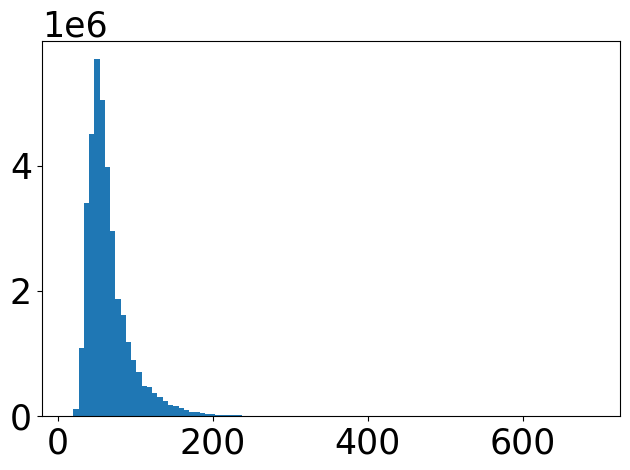

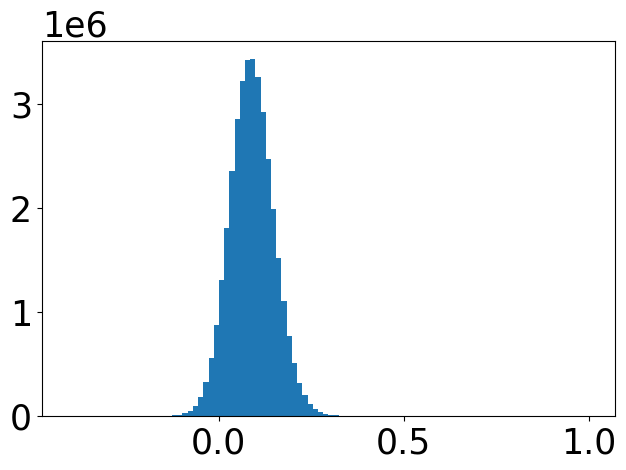

In [114]:
plt.hist(1./ag_cov_norm.flatten(), bins=100)
plt.show()
plt.hist(ag_corr.flatten(), bins=100)
plt.show()

In [57]:
np.savez('corr_matrix_embryos_withE45_old_th5.npz', corr=ag_corr_old)
np.savez('corr_matrix_embryos_withE45_you_th5.npz', corr=ag_corr_you)
np.savez('corr_matrix_embryos_withE45_mid_th5.npz', corr=ag_corr_mid)
np.savez('corr_matrix_embryos_withE45_mid1_th5.npz', corr=ag_corr_mid_1)
np.savez('corr_matrix_embryos_withE45_th5.npz', corr=ag_corr)

In [ ]:
idx_you = np.logical_and(np.nansum(~np.isnan(xpos), axis=1) > 2, age * 365./12 < 5)
idx_mid_1 = np.logical_and(np.nansum(~np.isnan(xpos), axis=1) > 2, np.logical_and(age * 365./12 > 5, age * 365./12 < 6))
idx_mid = np.logical_and(np.nansum(~np.isnan(xpos), axis=1) > 2, np.logical_and(age * 365./12 > 6, age * 365./12 < 7))
idx_old = np.logical_and(np.nansum(~np.isnan(xpos), axis=1) > 2, age * 365./12 > 7)

# ents = sparse_calc_probs_fast(xpos[idx_you][:,:100], xcov[idx_you][:,:100], order=2)
# ag_corr = anatools.sparse_corr_mat(sp.csr_matrix(xpos[idx_you][:,:100]), sp.csr_matrix(xcov[idx_you][:,:100]))
# ag_corr = anatools.sparse_corr_mat(sp.csr_matrix(xpos[idx_you][:,:1000]), sp.csr_matrix(xcov[idx_you][:,:1000]))
ag_corr_old = np.zeros((xpos.shape[1], xpos.shape[1]))
batch = 1000
nbatch = xpos.shape[1] // batch + 1
xpos_sp = sp.csr_matrix(np.nan_to_num(xpos[idx_old])).astype(np.float64)
xcov_sp = sp.csr_matrix(np.nan_to_num(xcov[idx_old])).astype(np.float64)
for i in trange(nbatch):
    idx = np.arange(i * batch, np.min([ (i + 1) * batch, xpos.shape[1]]))
    ag_corr_old[idx] = anatools.sparse_corr_mat_by_batch(xpos_sp, xcov_sp, idx=idx)

ag_corr_mid_1 = np.zeros((xpos.shape[1], xpos.shape[1]))
batch = 1000
nbatch = xpos.shape[1] // batch + 1
xpos_sp = sp.csr_matrix(np.nan_to_num(xpos[idx_mid_1])).astype(np.float64)
xcov_sp = sp.csr_matrix(np.nan_to_num(xcov[idx_mid_1])).astype(np.float64)
for i in trange(nbatch):
    idx = np.arange(i * batch, np.min([ (i + 1) * batch, xpos.shape[1]]))
    ag_corr_mid_1[idx] = anatools.sparse_corr_mat_by_batch(xpos_sp, xcov_sp, idx=idx)
    
ag_corr_mid = np.zeros((xpos.shape[1], xpos.shape[1]))
batch = 1000
nbatch = xpos.shape[1] // batch + 1
xpos_sp = sp.csr_matrix(np.nan_to_num(xpos[idx_mid])).astype(np.float64)
xcov_sp = sp.csr_matrix(np.nan_to_num(xcov[idx_mid])).astype(np.float64)
for i in trange(nbatch):
    idx = np.arange(i * batch, np.min([ (i + 1) * batch, xpos.shape[1]]))
    ag_corr_mid[idx] = anatools.sparse_corr_mat_by_batch(xpos_sp, xcov_sp, idx=idx)
    
# ents = sparse_calc_probs_fast(xpos[idx_you][:,:100], xcov[idx_you][:,:100], order=2)
# ag_corr = anatools.sparse_corr_mat(sp.csr_matrix(xpos[idx_you][:,:100]), sp.csr_matrix(xcov[idx_you][:,:100]))
# ag_corr = anatools.sparse_corr_mat(sp.csr_matrix(xpos[idx_you][:,:1000]), sp.csr_matrix(xcov[idx_you][:,:1000]))
ag_corr_you = np.zeros((xpos.shape[1], xpos.shape[1]))
batch = 1000
nbatch = xpos.shape[1] // batch + 1
xpos_sp = sp.csr_matrix(np.nan_to_num(xpos[idx_you])).astype(np.float64)
xcov_sp = sp.csr_matrix(np.nan_to_num(xcov[idx_you])).astype(np.float64)
for i in trange(nbatch):
    idx = np.arange(i * batch, np.min([ (i + 1) * batch, xpos.shape[1]]))
    ag_corr_you[idx] = anatools.sparse_corr_mat_by_batch(xpos_sp, xcov_sp, idx=idx)
    
    
# ents = sparse_calc_probs_fast(xpos[idx_you][:,:100], xcov[idx_you][:,:100], order=2)
# ag_corr = anatools.sparse_corr_mat(sp.csr_matrix(xpos[idx_you][:,:100]), sp.csr_matrix(xcov[idx_you][:,:100]))
# ag_corr = anatools.sparse_corr_mat(sp.csr_matrix(xpos[idx_you][:,:1000]), sp.csr_matrix(xcov[idx_you][:,:1000]))
ag_corr = np.zeros((xpos.shape[1], xpos.shape[1]))
batch = 502
nbatch = xpos.shape[1] // batch + 1
xpos_sp = sp.csr_matrix(np.nan_to_num(xpos)).astype(np.float64)
xcov_sp = sp.csr_matrix(np.nan_to_num(xcov)).astype(np.float64)
for i in trange(nbatch):
    idx = np.arange(i * batch, np.min([ (i + 1) * batch, xpos.shape[1]]))
    ag_corr[idx] = anatools.sparse_corr_mat_by_batch(xpos_sp, xcov_sp, idx=idx)

In [61]:
corr_th = 0.4
jdx_coreg = np.zeros(ag_corr.shape[0]) == 1
for i in trange(ag_corr.shape[0]):
    idx = np.abs(ag_corr[i,:]) > corr_th
    idx_old_cpg = np.abs(ag_corr_old[i,:]) > corr_th
    idx_you_cpg = np.abs(ag_corr_you[i,:]) > corr_th
    idx_mid_cpg = np.abs(ag_corr_mid[i,:]) > corr_th
    idx_mid1_cpg = np.abs(ag_corr_mid_1[i,:]) > corr_th
    
    idx_tot = 1. * idx
    idx_tot += 1. * idx_old_cpg
    idx_tot += 1. * idx_you_cpg
    idx_tot += 1. * idx_mid_cpg
    idx_tot += 1. * idx_mid1_cpg
    
#     idx = np.logical_and(idx, idx_old_cpg)
#     idx = np.logical_and(idx, idx_you_cpg)
#     idx = np.logical_and(idx, idx_mid_cpg)
#     # if (np.sum(idx) > 1.5) and (np.sum(idx_you) > 1.5) and (np.sum(idx_old) > 1.5):
    if (np.sum(idx_tot > 3.5) > 1.5):
        jdx_coreg[idx_tot > 3.5] = True

100%|█████████████████████████████████████| 6000/6000 [00:00<00:00, 7364.34it/s]


In [64]:
corr_th = 0.5
jdx_coreg = np.zeros(ag_corr.shape[0]) == 1
for i in trange(ag_corr.shape[0]):
    idx = np.abs(ag_corr[i,:]) > corr_th
    idx_old_cpg = np.abs(ag_corr_old[i,:]) > corr_th
    idx_you_cpg = np.abs(ag_corr_you[i,:]) > corr_th
    idx_mid_cpg = np.abs(ag_corr_mid[i,:]) > corr_th
    idx_mid1_cpg = np.abs(ag_corr_mid_1[i,:]) > corr_th
    
    idx_tot = 1. * idx
    idx_tot += 1. * idx_old_cpg
    idx_tot += 1. * idx_you_cpg
    idx_tot += 1. * idx_mid_cpg
    idx_tot += 1. * idx_mid1_cpg
    
#     idx = np.logical_and(idx, idx_old_cpg)
#     idx = np.logical_and(idx, idx_you_cpg)
#     idx = np.logical_and(idx, idx_mid_cpg)
#     # if (np.sum(idx) > 1.5) and (np.sum(idx_you) > 1.5) and (np.sum(idx_old) > 1.5):
    if (np.sum(idx_tot > 3.5) > 1.5):
        jdx_coreg[idx_tot > 3.5] = True

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:00<00:00, 6785.52it/s]


In [100]:
corr_th = 0.5
jdx_coreg = np.zeros(ag_corr.shape[0]) == 1
for i in trange(ag_corr.shape[0]):
    idx = np.abs(ag_corr[i,:]) > corr_th
    # idx_old_cpg = np.abs(ag_corr_old[i,:]) > corr_th
    # idx_you_cpg = np.abs(ag_corr_you[i,:]) > corr_th
    # idx_mid_cpg = np.abs(ag_corr_mid[i,:]) > corr_th
    # idx_mid1_cpg = np.abs(ag_corr_mid_1[i,:]) > corr_th
    
    idx = np.logical_or(np.abs(ag_corr[i,:]) > corr_th, np.isnan(ag_corr[i,:]))
    
    idx_tot = 1. * idx
    # idx_tot += 1. * idx_old_cpg
    # idx_tot += 1. * idx_you_cpg
    # idx_tot += 1. * idx_mid_cpg
    # idx_tot += 1. * idx_mid1_cpg
    
#     idx = np.logical_and(idx, idx_old_cpg)
#     idx = np.logical_and(idx, idx_you_cpg)
#     idx = np.logical_and(idx, idx_mid_cpg)
#     # if (np.sum(idx) > 1.5) and (np.sum(idx_you) > 1.5) and (np.sum(idx_old) > 1.5):
    if (np.sum(idx_tot > 0.5) > 1.5):
        jdx_coreg[idx_tot > 0.5] = True

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:00<00:00, 16676.13it/s]


In [103]:
corr_ths = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
nums = []
for corr_th in corr_ths:
    jdx_coreg = np.zeros(ag_corr.shape[0]) == 1
    for i in trange(ag_corr.shape[0]):
        idx = np.abs(ag_corr[i,:]) > corr_th
        # idx_old_cpg = np.abs(ag_corr_old[i,:]) > corr_th
        # idx_you_cpg = np.abs(ag_corr_you[i,:]) > corr_th
        # idx_mid_cpg = np.abs(ag_corr_mid[i,:]) > corr_th
        # idx_mid1_cpg = np.abs(ag_corr_mid_1[i,:]) > corr_th

        # idx = np.logical_or(np.abs(ag_corr[i,:]) > corr_th, np.isnan(ag_corr[i,:]))

        idx_tot = 1. * idx
        # idx_tot += 1. * idx_old_cpg
        # idx_tot += 1. * idx_you_cpg
        # idx_tot += 1. * idx_mid_cpg
        # idx_tot += 1. * idx_mid1_cpg

    #     idx = np.logical_and(idx, idx_old_cpg)
    #     idx = np.logical_and(idx, idx_you_cpg)
    #     idx = np.logical_and(idx, idx_mid_cpg)
    #     # if (np.sum(idx) > 1.5) and (np.sum(idx_you) > 1.5) and (np.sum(idx_old) > 1.5):
        if (np.sum(idx_tot > 0.5) > 1.5):
            jdx_coreg[idx_tot > 0.5] = True
    nums.append(np.sum(jdx_coreg))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:00<00:00, 23046.24it/s]


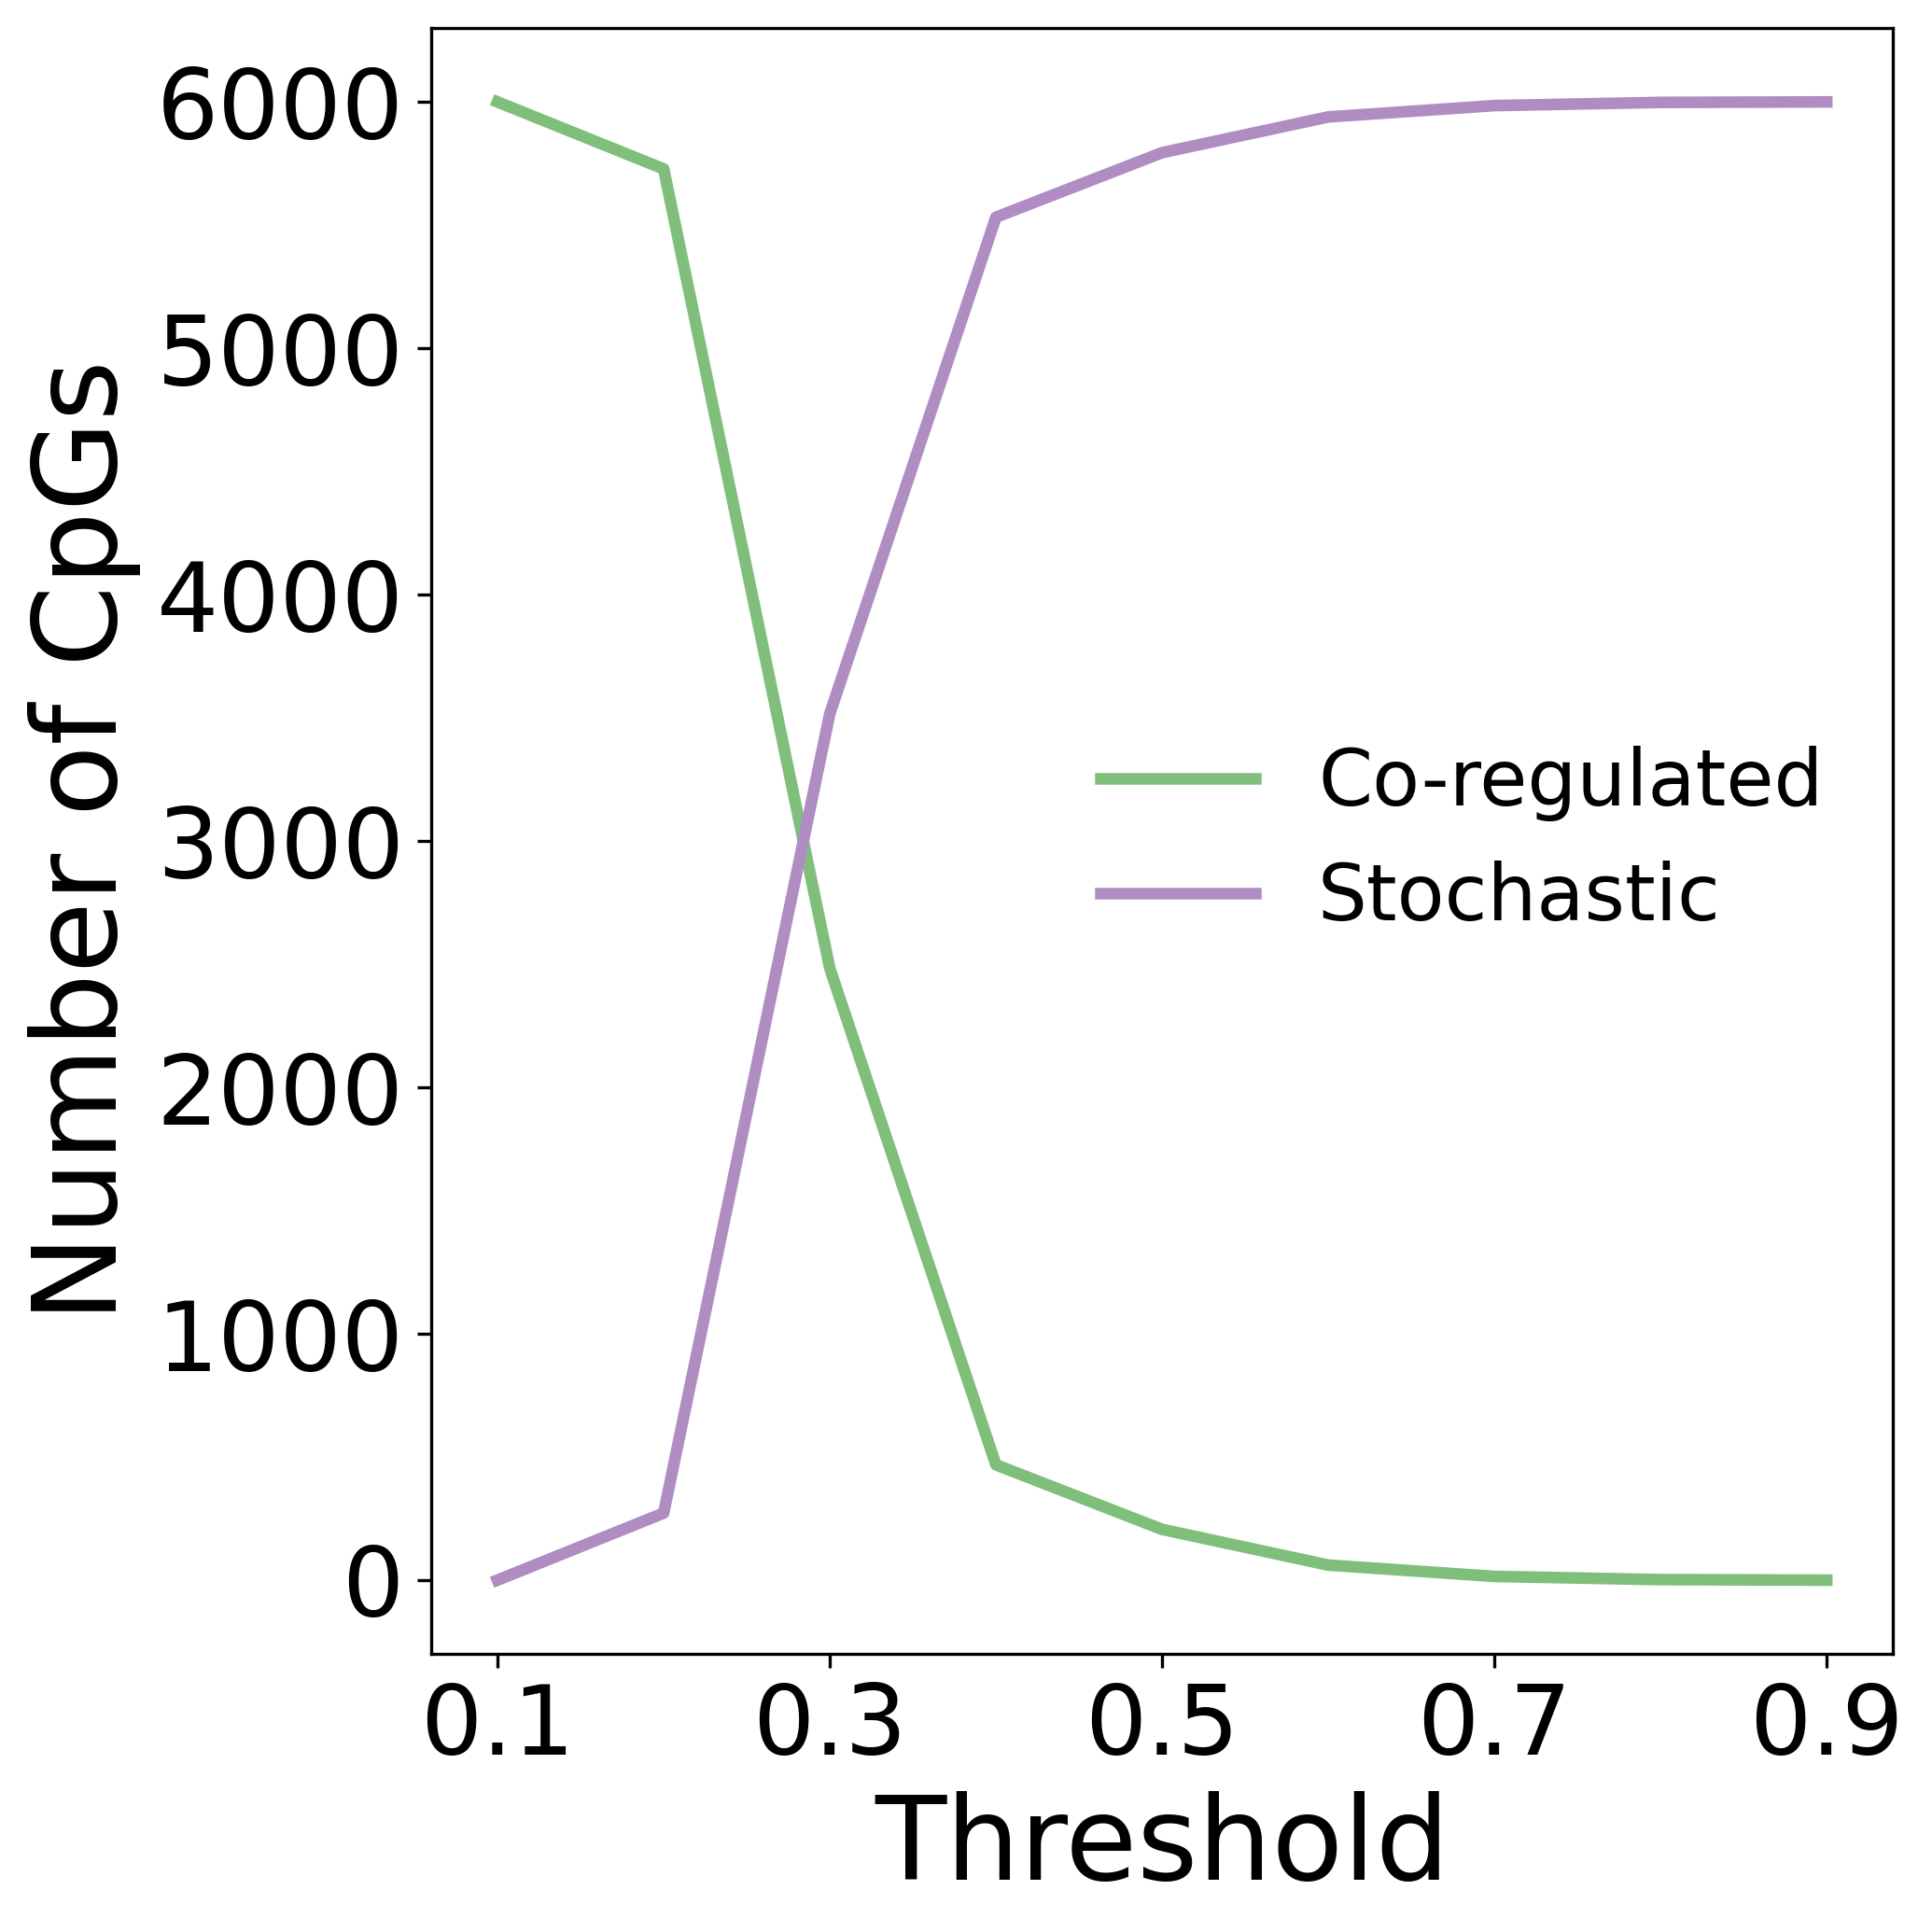

In [107]:
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.style.use('../Stochastic aging/pics/meth.mplstyle')
plt.figure(figsize=(7,7), dpi=300)
lab2name = {'coreg': 'Co-regulated',
            'stoch': 'Stochastic',
            'rand': 'Background'}
lab2color = {'coreg': '#7fbf7b',
            'stoch': '#af8dc3',
            'rand': '#999999'}
groups = ['coreg', 'stoch']
for group in groups:# + ['rand']:
    try:
        if group == 'coreg':
            numplot = nums
        else:
            numplot = 6000 - np.array(nums)
        plt.plot(corr_ths, numplot, label=lab2name[group], 
                     color=lab2color[group], #lw=3,#capsize=5, 
                     # capthick=3,
            )
        # plt.fill_between(corr_ths, scores[group]['25%'], scores[group]['75%'], label=group, lw=1, alpha=0.3)
    except:
        continue
plt.xlabel('Threshold')
plt.ylabel(f'Number of CpGs')
# if score == 'phyloP':
#     plt.yticks([0.1, 0.2, 0.30, 0.4, 0.5])
#     plt.legend(loc='upper left')

# elif score == 'phastCons':
    # plt.yticks([0.15, 0.20, 0.25])
plt.legend(loc='center right')

# plt.xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
plt.xticks([0.1, 0.3, 0.5, 0.7, 0.9])
plt.savefig(f'PICS/NumOfCpGs_devlopment.png', format='png', dpi=300)
plt.show()

In [108]:
corr_ths = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
nums = []
for corr_th in corr_ths:
    jdx_coreg = np.zeros(ag_corr.shape[0]) == 1
    for i in trange(ag_corr.shape[0]):
        idx = np.abs(ag_corr[i,:]) > corr_th
        idx_old_cpg = np.abs(ag_corr_old[i,:]) > corr_th
        idx_you_cpg = np.abs(ag_corr_you[i,:]) > corr_th
        idx_mid_cpg = np.abs(ag_corr_mid[i,:]) > corr_th
        idx_mid1_cpg = np.abs(ag_corr_mid_1[i,:]) > corr_th

        # idx = np.logical_or(np.abs(ag_corr[i,:]) > corr_th, np.isnan(ag_corr[i,:]))

        idx_tot = 1. * idx
        idx_tot += 1. * idx_old_cpg
        idx_tot += 1. * idx_you_cpg
        idx_tot += 1. * idx_mid_cpg
        idx_tot += 1. * idx_mid1_cpg

    #     idx = np.logical_and(idx, idx_old_cpg)
    #     idx = np.logical_and(idx, idx_you_cpg)
    #     idx = np.logical_and(idx, idx_mid_cpg)
    #     # if (np.sum(idx) > 1.5) and (np.sum(idx_you) > 1.5) and (np.sum(idx_old) > 1.5):
        if (np.sum(idx_tot > 4.5) > 1.5):
            jdx_coreg[idx_tot > 4.5] = True
    nums.append(np.sum(jdx_coreg))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:00<00:00, 7268.59it/s]


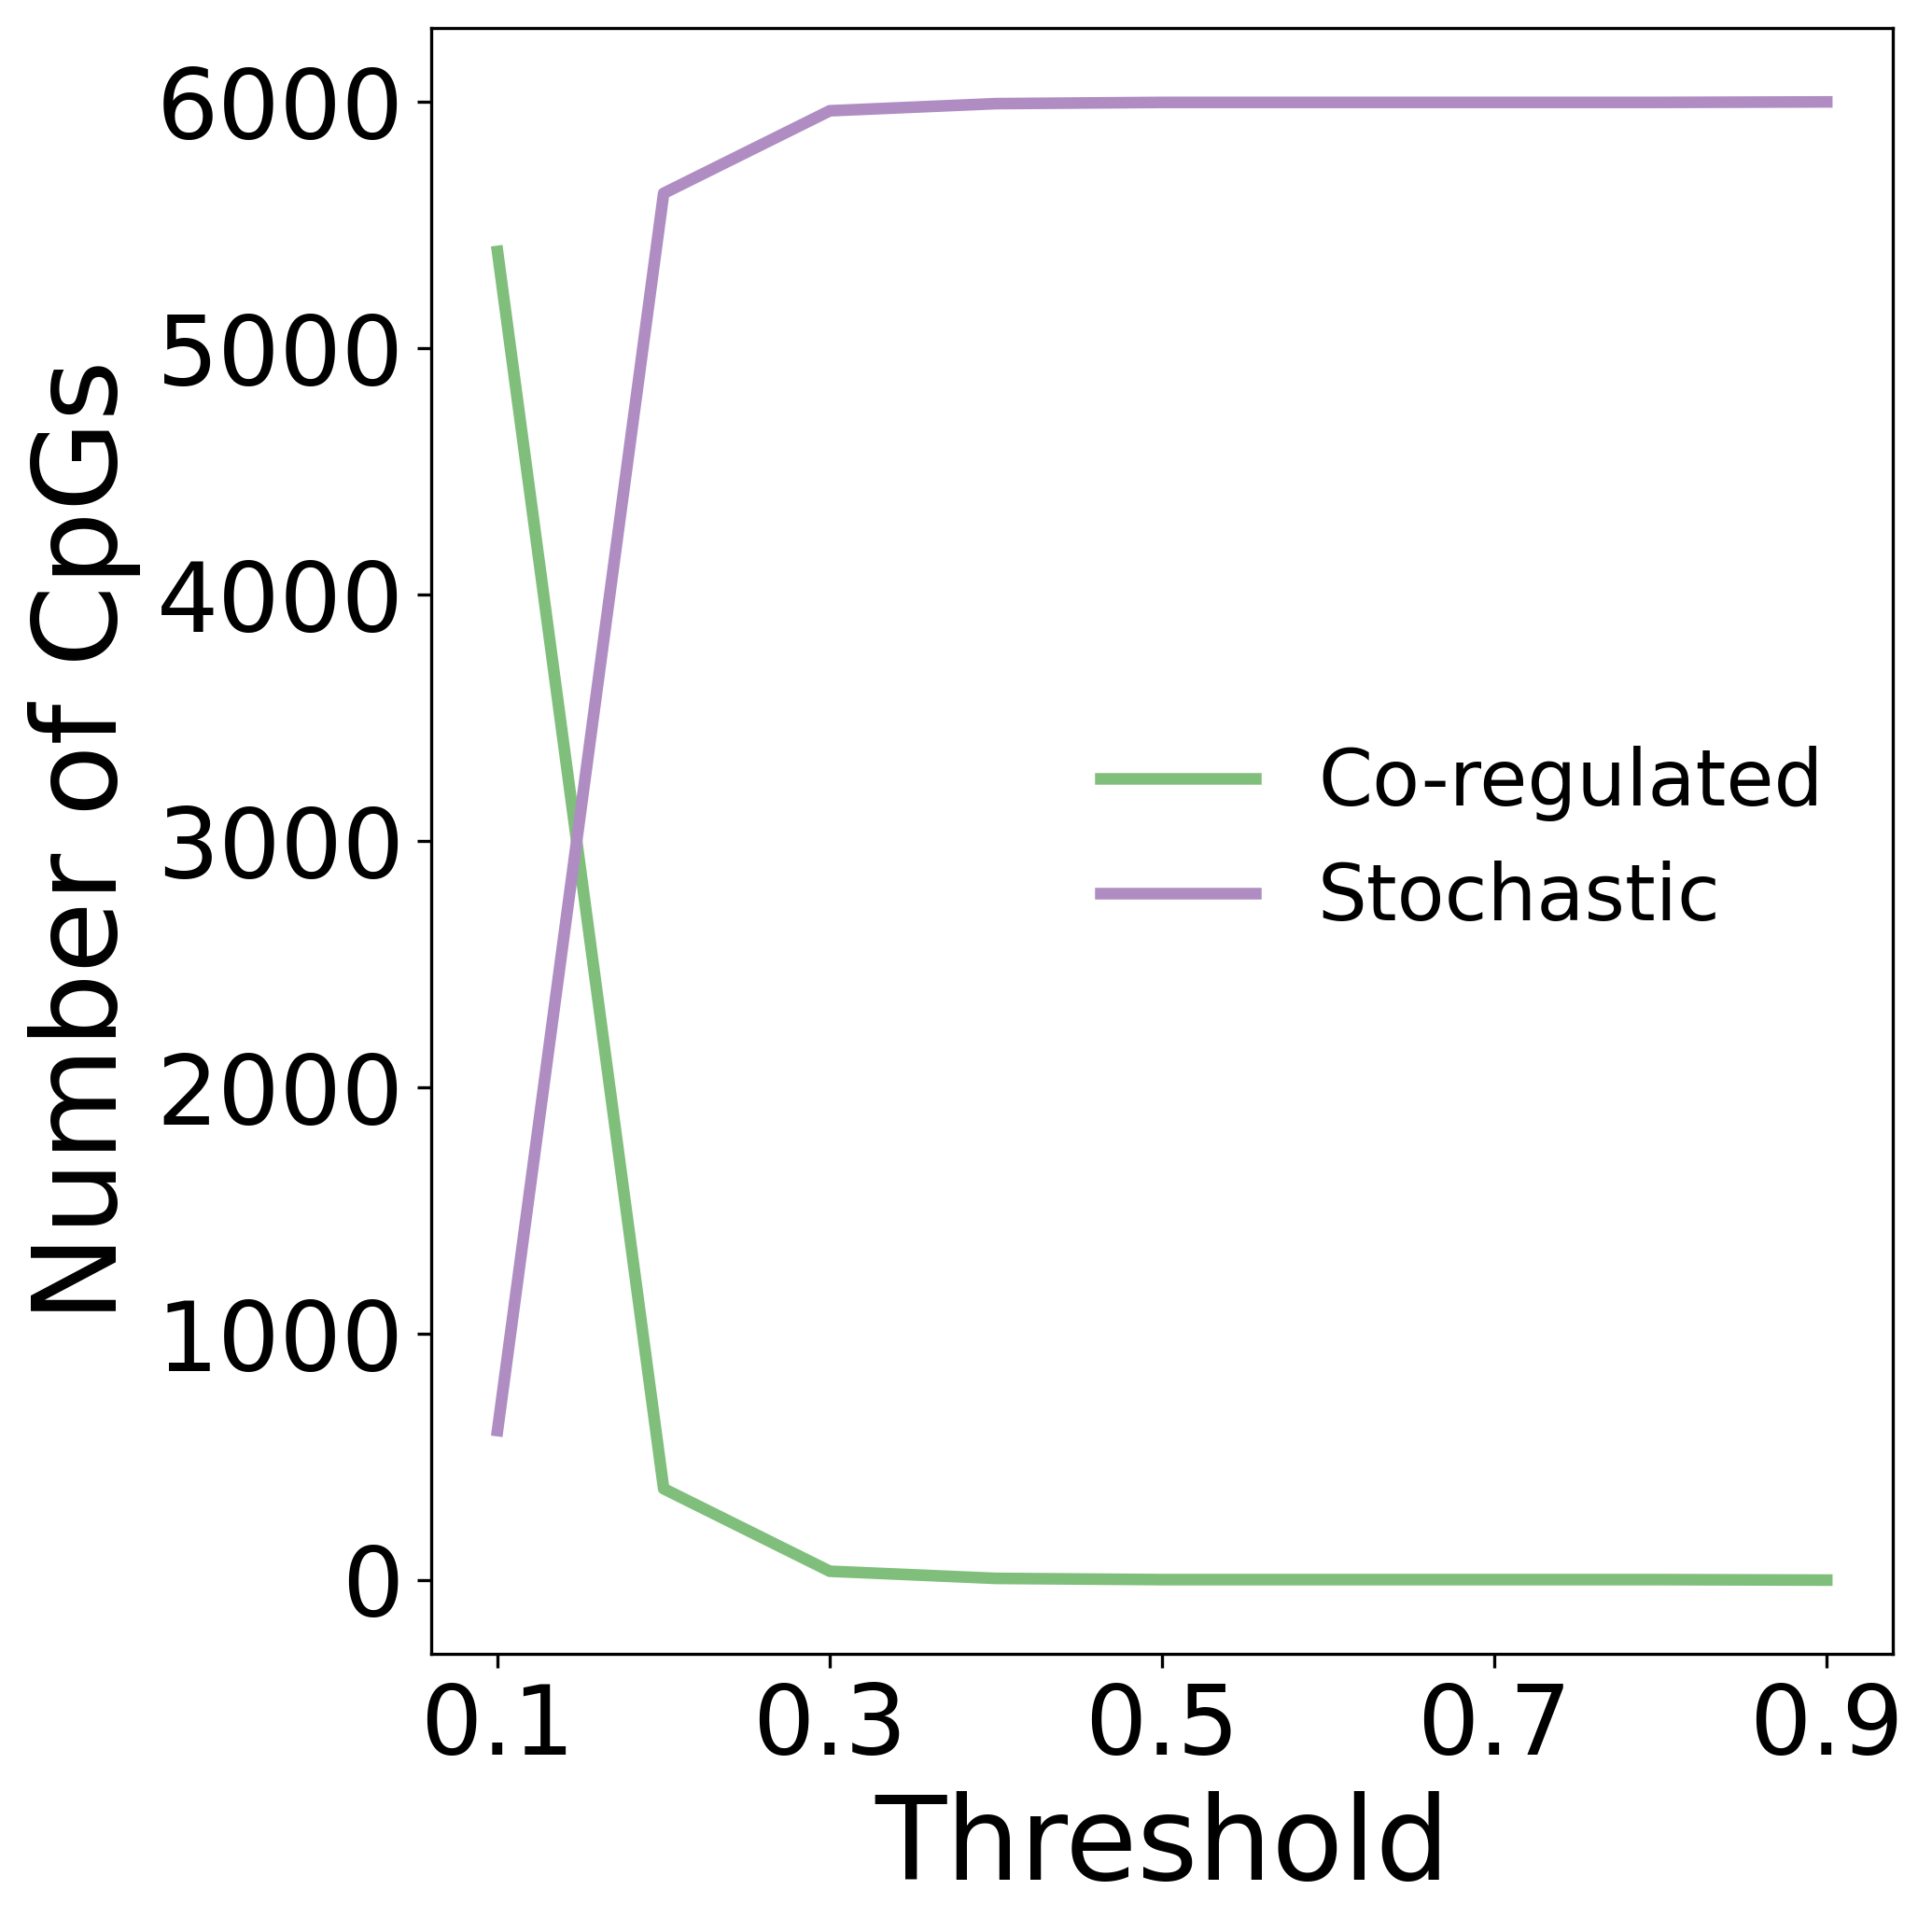

In [109]:
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.style.use('../Stochastic aging/pics/meth.mplstyle')
plt.figure(figsize=(7,7), dpi=300)
lab2name = {'coreg': 'Co-regulated',
            'stoch': 'Stochastic',
            'rand': 'Background'}
lab2color = {'coreg': '#7fbf7b',
            'stoch': '#af8dc3',
            'rand': '#999999'}
groups = ['coreg', 'stoch']
for group in groups:# + ['rand']:
    try:
        if group == 'coreg':
            numplot = nums
        else:
            numplot = 6000 - np.array(nums)
        plt.plot(corr_ths, numplot, label=lab2name[group], 
                     color=lab2color[group], #lw=3,#capsize=5, 
                     # capthick=3,
            )
        # plt.fill_between(corr_ths, scores[group]['25%'], scores[group]['75%'], label=group, lw=1, alpha=0.3)
    except:
        continue
plt.xlabel('Threshold')
plt.ylabel(f'Number of CpGs')
# if score == 'phyloP':
#     plt.yticks([0.1, 0.2, 0.30, 0.4, 0.5])
#     plt.legend(loc='upper left')

# elif score == 'phastCons':
    # plt.yticks([0.15, 0.20, 0.25])
plt.legend(loc='center right')

# plt.xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
plt.xticks([0.1, 0.3, 0.5, 0.7, 0.9])
plt.savefig(f'PICS/NumOfCpGs_devlopment_strict.png', format='png', dpi=300)
plt.show()

In [115]:
corr_ths = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
nums = []
for corr_th in corr_ths:
    jdx_coreg = np.zeros(ag_corr.shape[0]) == 1
    for i in trange(ag_corr.shape[0]):
        # idx = np.abs(ag_corr[i,:]) > corr_th
        # idx_old_cpg = np.abs(ag_corr_old[i,:]) > corr_th
        # idx_you_cpg = np.abs(ag_corr_you[i,:]) > corr_th
        # idx_mid_cpg = np.abs(ag_corr_mid[i,:]) > corr_th
        # idx_mid1_cpg = np.abs(ag_corr_mid_1[i,:]) > corr_th

        idx = np.logical_or(np.abs(ag_corr[i,:]) > corr_th, np.isnan(ag_corr[i,:]))
        idx_old_cpg = np.logical_or(np.abs(ag_corr_old[i,:]) > corr_th, np.isnan(ag_corr_old[i,:]))
        idx_you_cpg = np.logical_or(np.abs(ag_corr_you[i,:]) > corr_th, np.isnan(ag_corr_you[i,:]))
        idx_mid_cpg = np.logical_or(np.abs(ag_corr_mid[i,:]) > corr_th, np.isnan(ag_corr_mid[i,:]))
        idx_mid1_cpg = np.logical_or(np.abs(ag_corr_mid_1[i,:]) > corr_th, np.isnan(ag_corr_mid_1[i,:]))
        
        idx_tot = 1. * idx
        idx_tot += 1. * idx_old_cpg
        idx_tot += 1. * idx_you_cpg
        idx_tot += 1. * idx_mid_cpg
        idx_tot += 1. * idx_mid1_cpg

    #     idx = np.logical_and(idx, idx_old_cpg)
    #     idx = np.logical_and(idx, idx_you_cpg)
    #     idx = np.logical_and(idx, idx_mid_cpg)
    #     # if (np.sum(idx) > 1.5) and (np.sum(idx_you) > 1.5) and (np.sum(idx_old) > 1.5):
        if (np.sum(idx_tot > 4.5) > 1.5):
            jdx_coreg[idx_tot > 4.5] = True
    nums.append(np.sum(jdx_coreg))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:01<00:00, 5661.21it/s]


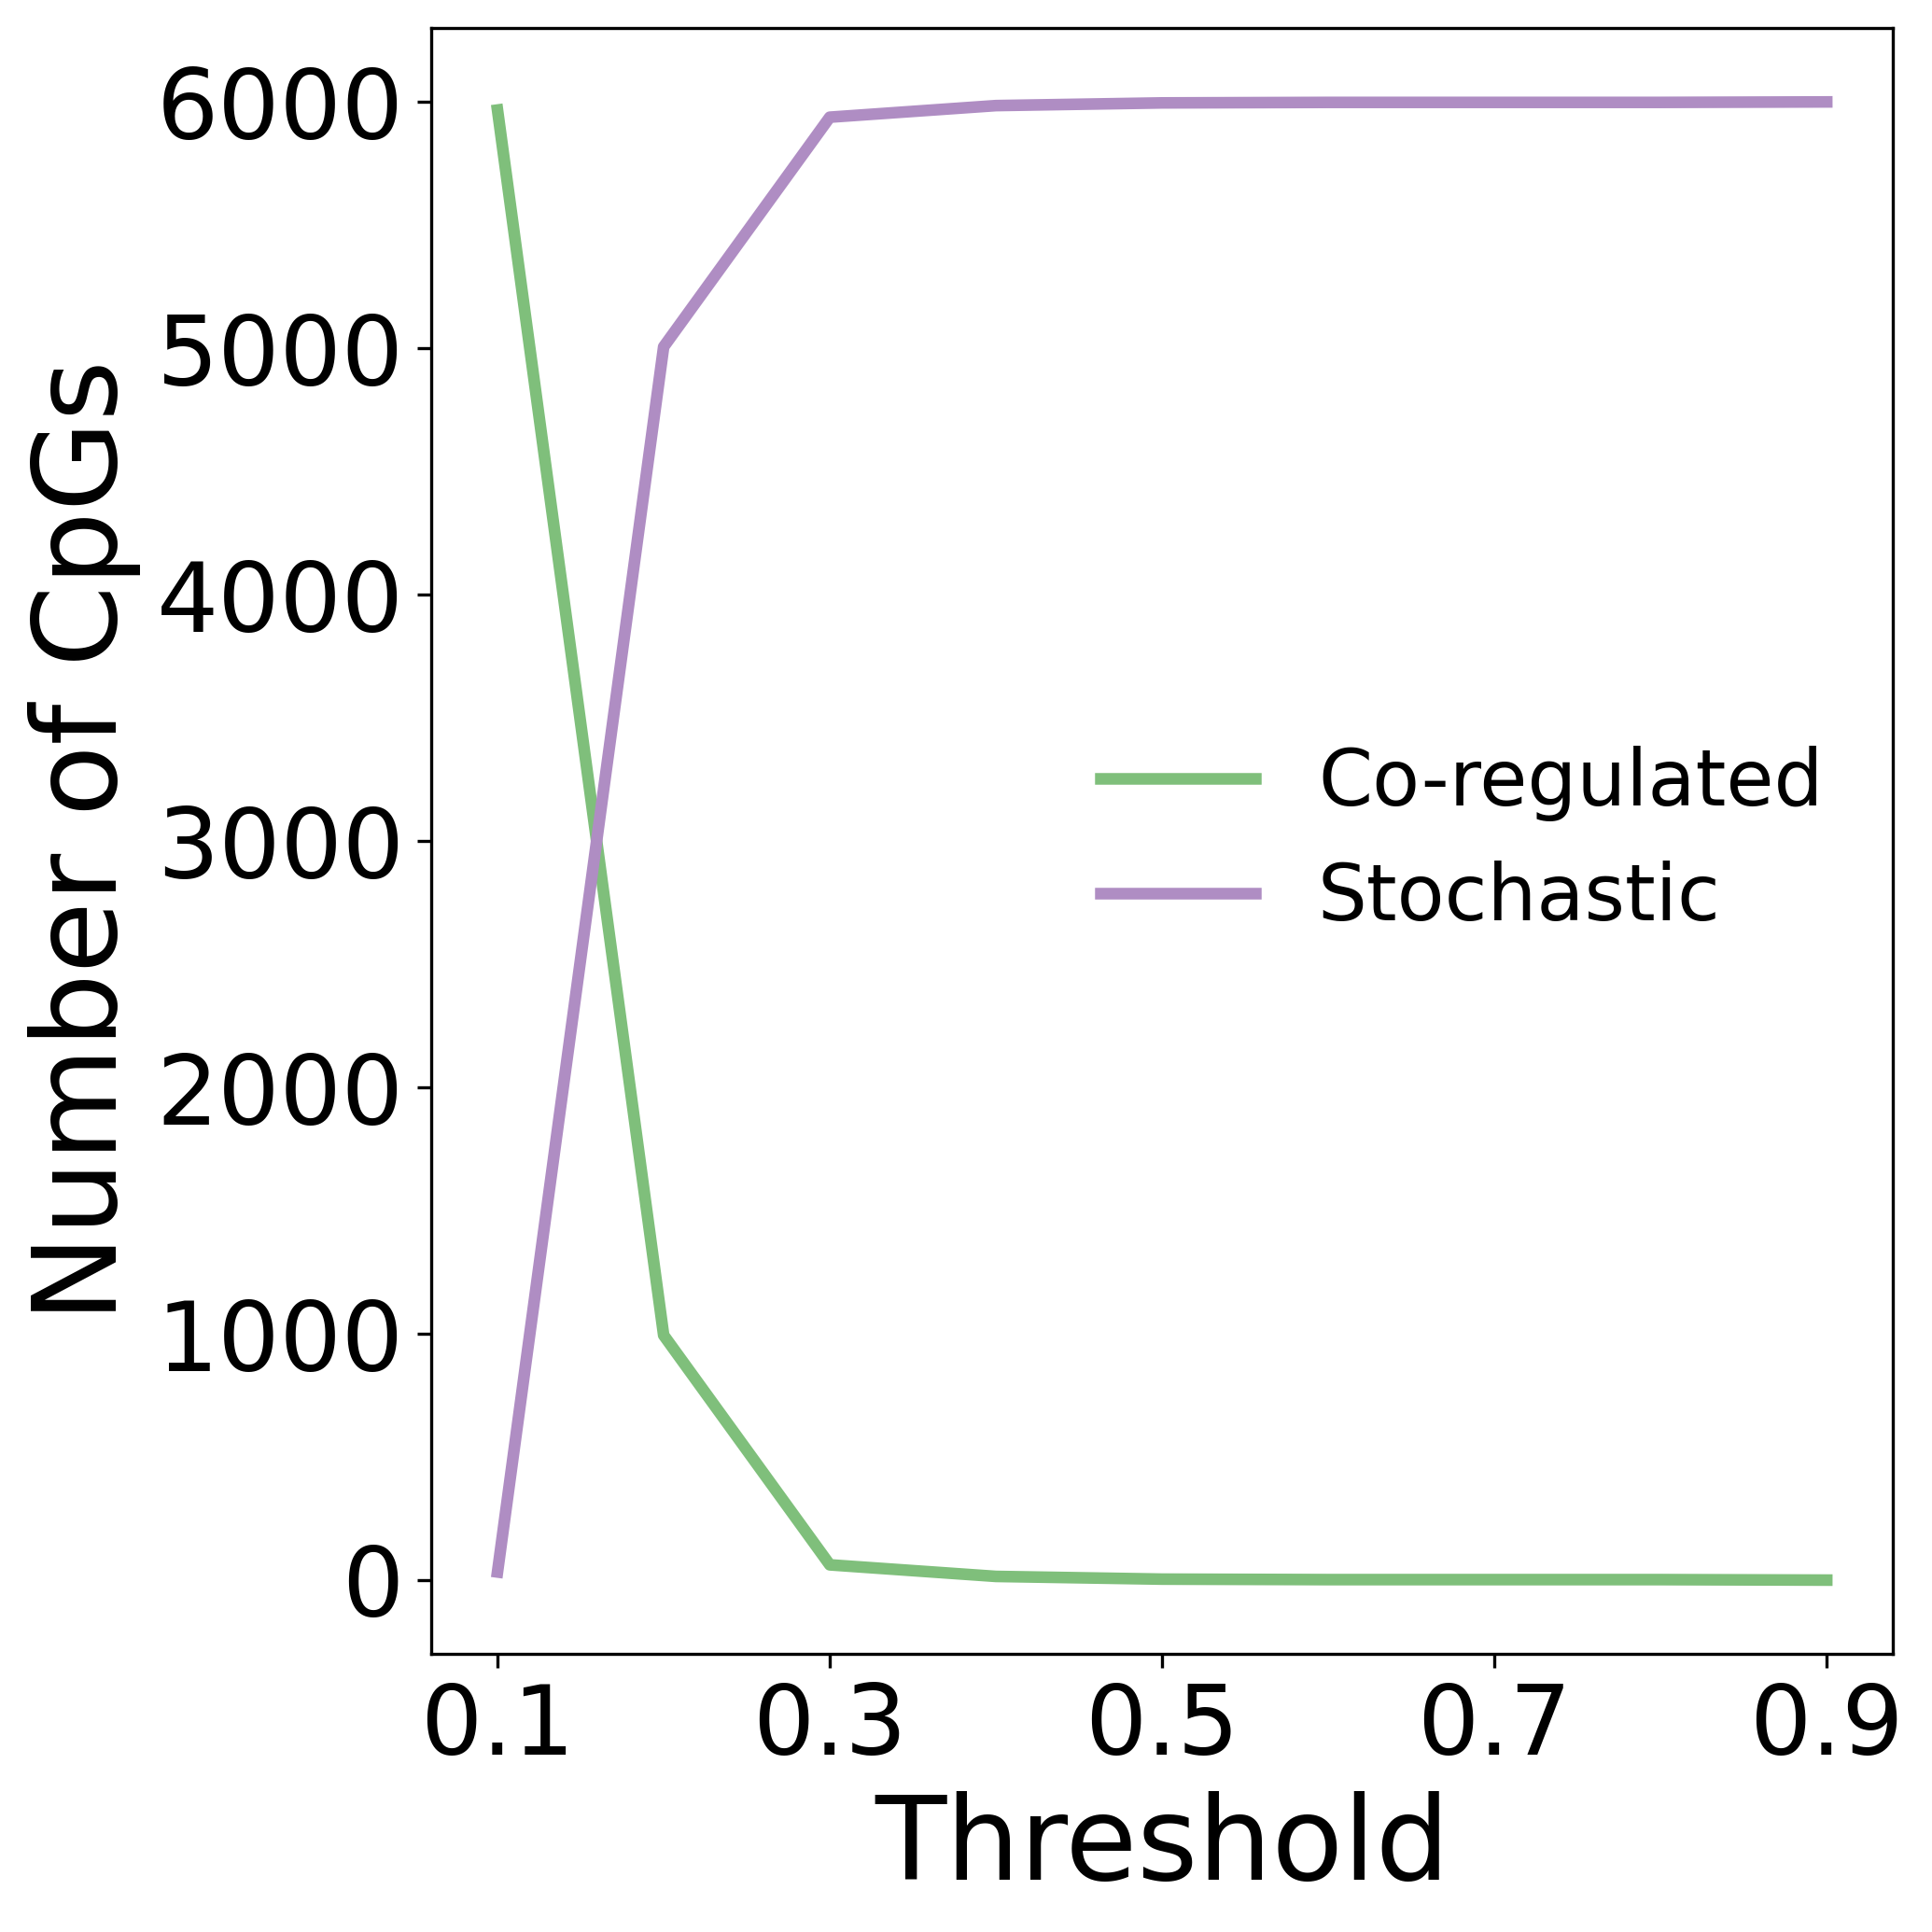

In [116]:
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.style.use('../Stochastic aging/pics/meth.mplstyle')
plt.figure(figsize=(7,7), dpi=300)
lab2name = {'coreg': 'Co-regulated',
            'stoch': 'Stochastic',
            'rand': 'Background'}
lab2color = {'coreg': '#7fbf7b',
            'stoch': '#af8dc3',
            'rand': '#999999'}
groups = ['coreg', 'stoch']
for group in groups:# + ['rand']:
    try:
        if group == 'coreg':
            numplot = nums
        else:
            numplot = 6000 - np.array(nums)
        plt.plot(corr_ths, numplot, label=lab2name[group], 
                     color=lab2color[group], #lw=3,#capsize=5, 
                     # capthick=3,
            )
        # plt.fill_between(corr_ths, scores[group]['25%'], scores[group]['75%'], label=group, lw=1, alpha=0.3)
    except:
        continue
plt.xlabel('Threshold')
plt.ylabel(f'Number of CpGs')
# if score == 'phyloP':
#     plt.yticks([0.1, 0.2, 0.30, 0.4, 0.5])
#     plt.legend(loc='upper left')

# elif score == 'phastCons':
    # plt.yticks([0.15, 0.20, 0.25])
plt.legend(loc='center right')

# plt.xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
plt.xticks([0.1, 0.3, 0.5, 0.7, 0.9])
plt.savefig(f'PICS/NumOfCpGs_devlopment_accept_nans.png', format='png', dpi=300)
plt.show()

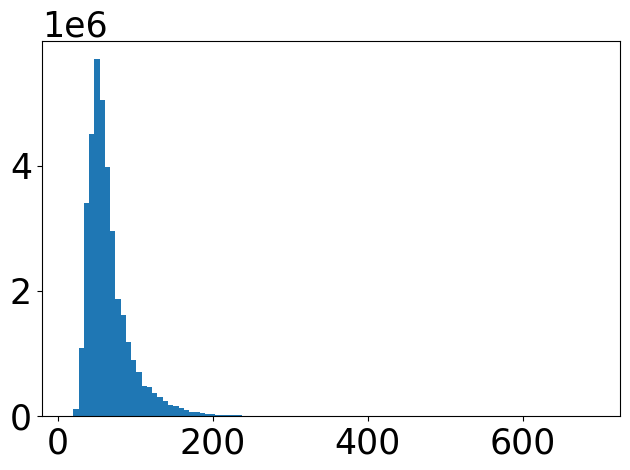

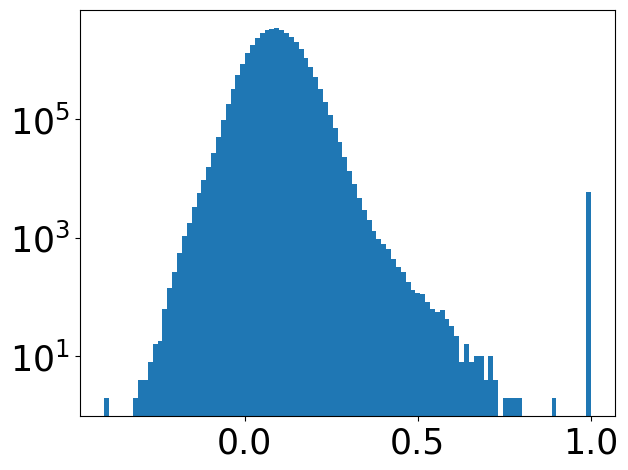

0.08993642059019111


In [206]:
plt.hist(1./ag_cov_norm.flatten(), bins=100)
plt.show()
plt.hist(ag_corr.flatten(), bins=100, log=True)
plt.show()
print(np.nanmean(ag_corr.flatten()))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


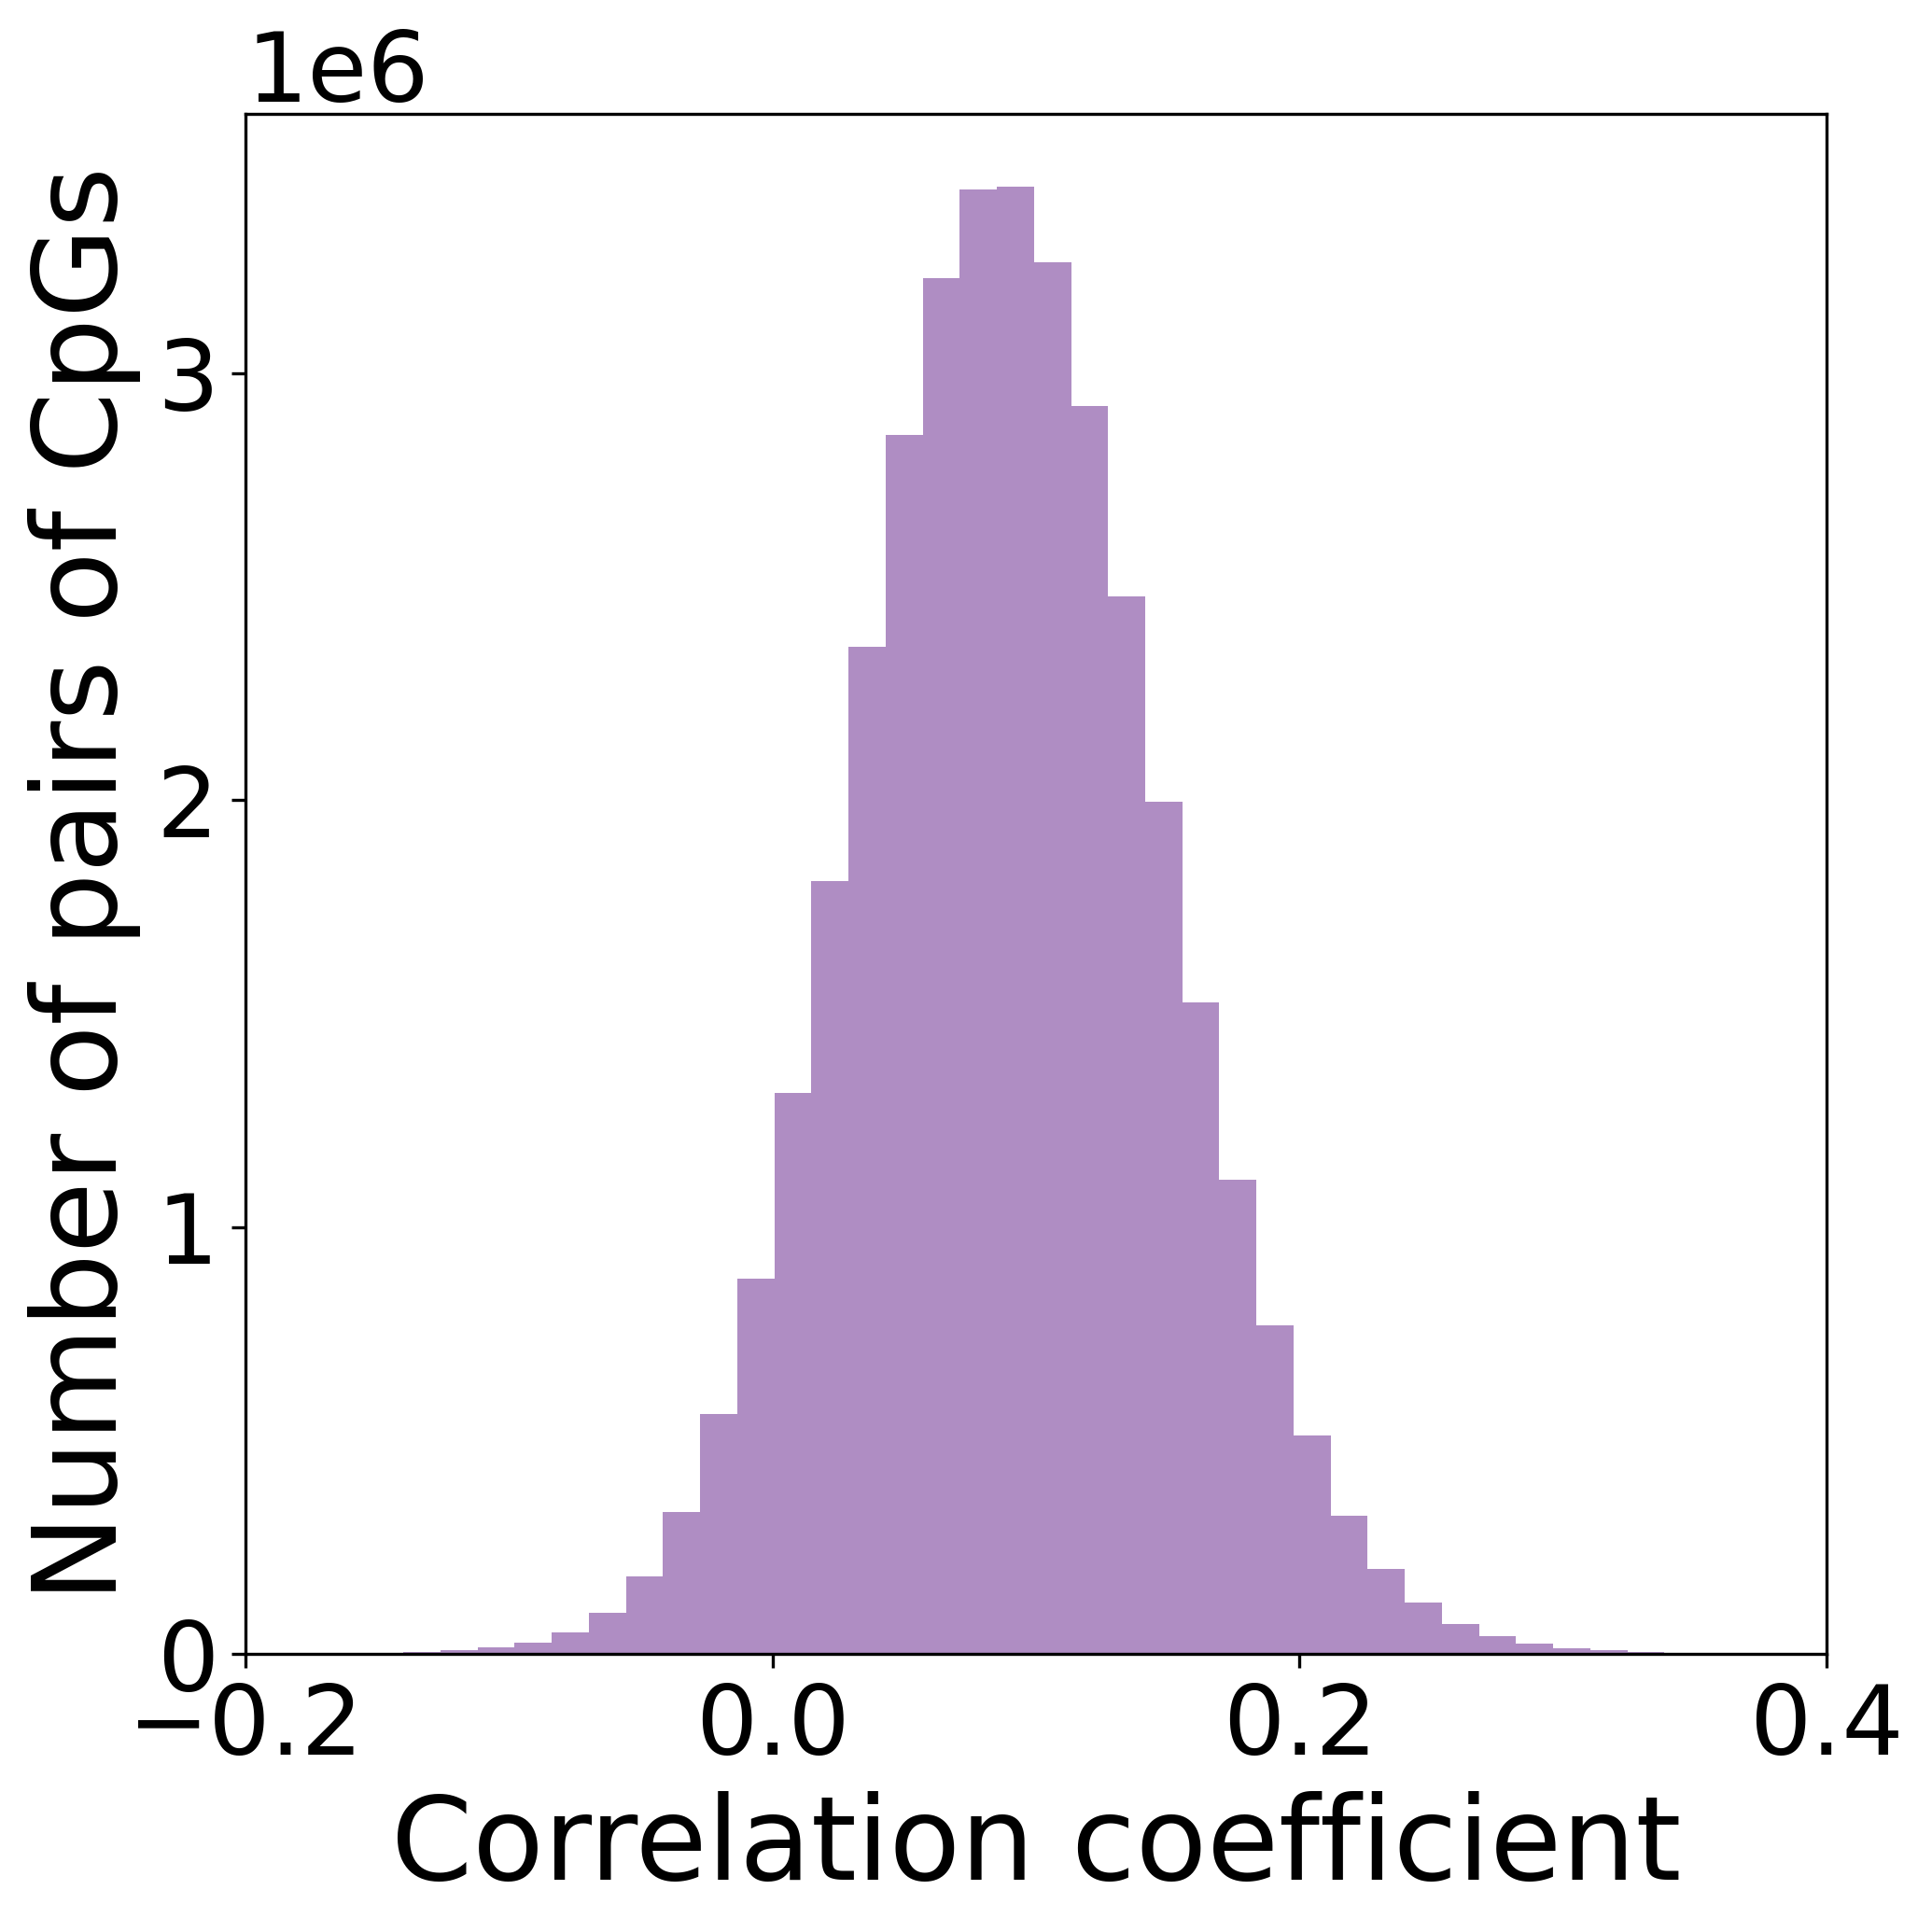

In [214]:

import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.style.use('../Stochastic aging/pics/meth.mplstyle')
plt.figure(figsize=(7,7), dpi=300)
lab2name = {'coreg': 'Co-regulated',
            'stoch': 'Stochastic',
            'rand': 'Background'}
lab2color = {'coreg': '#7fbf7b',
            'stoch': '#af8dc3',
            'rand': '#999999'}
groups = ['coreg', 'stoch']
plt.hist(ag_corr.flatten(), #log=True, 
         bins=100, color='#af8dc3')
plt.xlabel('Correlation coefficient')
plt.ylabel(f'Number of pairs of CpGs')
# if score == 'phyloP':
#     plt.yticks([0.1, 0.2, 0.30, 0.4, 0.5])
#     plt.legend(loc='upper left')

# elif score == 'phastCons':
    # plt.yticks([0.15, 0.20, 0.25])
plt.legend(loc='center right')
# plt.xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
# plt.xticks([0.1, 0.3, 0.5, 0.7, 0.9])
plt.xlim([-0.2, 0.4])
plt.savefig(f'PICS/Histogram_correlation_devlopment_accept_nans.png', format='png', dpi=300)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


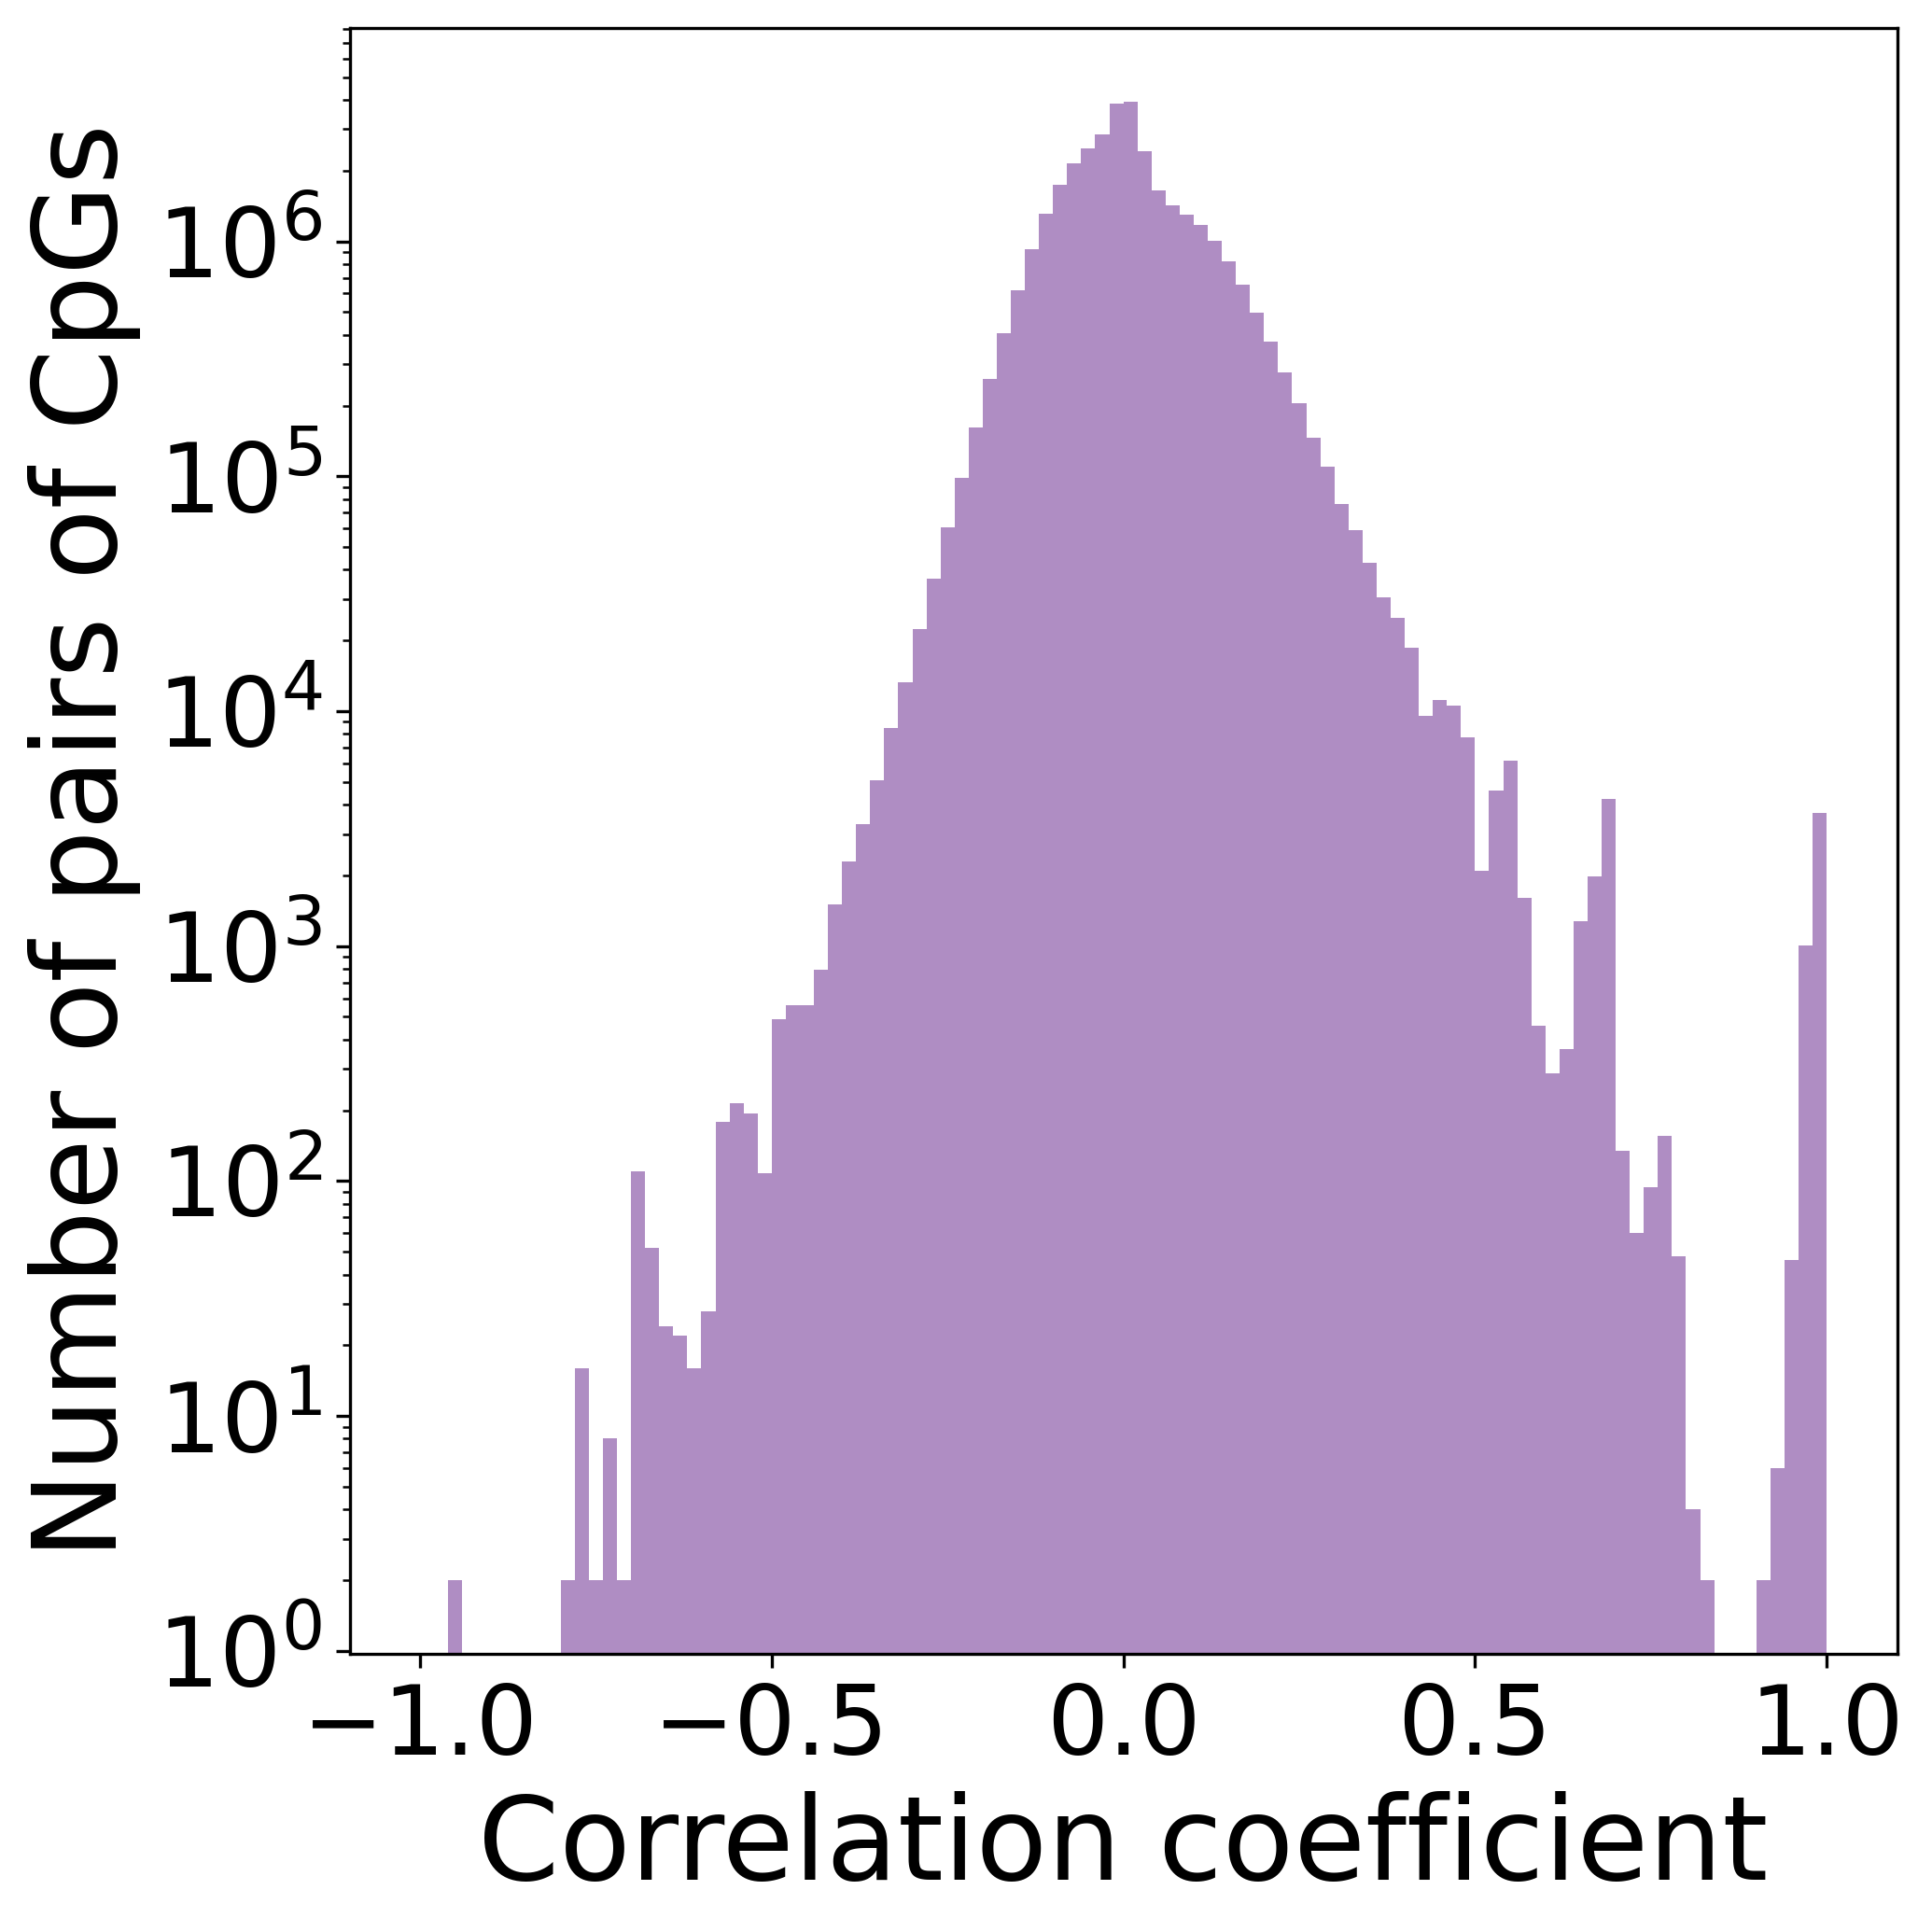

In [211]:

import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.style.use('../Stochastic aging/pics/meth.mplstyle')
plt.figure(figsize=(7,7), dpi=300)
lab2name = {'coreg': 'Co-regulated',
            'stoch': 'Stochastic',
            'rand': 'Background'}
lab2color = {'coreg': '#7fbf7b',
            'stoch': '#af8dc3',
            'rand': '#999999'}
groups = ['coreg', 'stoch']
plt.hist(ag_corr_you.flatten(), log=True, bins=100, range=(-1,1), color='#af8dc3')
plt.xlabel('Correlation coefficient')
plt.ylabel(f'Number of pairs of CpGs')
# if score == 'phyloP':
#     plt.yticks([0.1, 0.2, 0.30, 0.4, 0.5])
#     plt.legend(loc='upper left')

# elif score == 'phastCons':
    # plt.yticks([0.15, 0.20, 0.25])
plt.legend(loc='center right')
# plt.xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
# plt.xticks([0.1, 0.3, 0.5, 0.7, 0.9])
plt.xlim([-1.1,1.1])
plt.savefig(f'PICS/Histogram_correlation_development_you.png', format='png', dpi=300)
plt.show()

In [191]:
for corr_th in [0.25]:
    jdx_coreg = np.zeros(ag_corr.shape[0]) == 1
    for i in trange(ag_corr.shape[0]):
        # idx = np.abs(ag_corr[i,:]) > corr_th
        # idx_old_cpg = np.abs(ag_corr_old[i,:]) > corr_th
        # idx_you_cpg = np.abs(ag_corr_you[i,:]) > corr_th
        # idx_mid_cpg = np.abs(ag_corr_mid[i,:]) > corr_th
        # idx_mid1_cpg = np.abs(ag_corr_mid_1[i,:]) > corr_th

        idx = np.logical_or(np.abs(ag_corr[i,:]) > corr_th, np.isnan(ag_corr[i,:]))
        idx_old_cpg = np.logical_or(np.abs(ag_corr_old[i,:]) > corr_th, np.isnan(ag_corr_old[i,:]))
        idx_you_cpg = np.logical_or(np.abs(ag_corr_you[i,:]) > corr_th, np.isnan(ag_corr_you[i,:]))
        idx_mid_cpg = np.logical_or(np.abs(ag_corr_mid[i,:]) > corr_th, np.isnan(ag_corr_mid[i,:]))
        idx_mid1_cpg = np.logical_or(np.abs(ag_corr_mid_1[i,:]) > corr_th, np.isnan(ag_corr_mid_1[i,:]))
        
        idx_tot = 1. * idx
        idx_tot += 1. * idx_old_cpg
        idx_tot += 1. * idx_you_cpg
        idx_tot += 1. * idx_mid_cpg
        idx_tot += 1. * idx_mid1_cpg

    #     idx = np.logical_and(idx, idx_old_cpg)
    #     idx = np.logical_and(idx, idx_you_cpg)
    #     idx = np.logical_and(idx, idx_mid_cpg)
    #     # if (np.sum(idx) > 1.5) and (np.sum(idx_you) > 1.5) and (np.sum(idx_old) > 1.5):
        if (np.sum(idx_tot > 4.5) > 1.5):
            jdx_coreg[idx_tot > 4.5] = True
    nums.append(np.sum(jdx_coreg))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:01<00:00, 5391.83it/s]


In [192]:
np.sum(jdx_coreg), jdx_coreg.shape

(191, (6000,))

In [62]:
np.sum(jdx_coreg), jdx_coreg.shape

(304, (6000,))

In [74]:
304/6000

0.050666666666666665

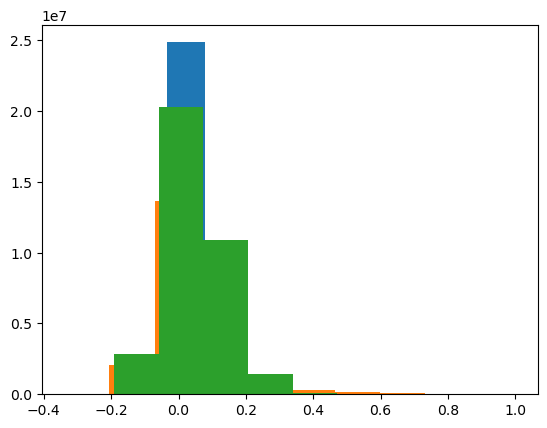

In [63]:
plt.hist(ag_corr.flatten())
plt.hist(ag_corr_you.flatten())
plt.hist(ag_corr_old.flatten())
plt.show()

In [193]:
print(jdx_coreg.shape, np.sum(jdx_coreg))
idx_filter = jdx_coreg

(6000,) 191


In [194]:
121/502, 381/502

(0.2410358565737052, 0.7589641434262948)

# Fig. 5b

['E4.5', 'E5.5', 'E6.5', 'E7.5']
Categories (4, object): ['E4.5', 'E5.5', 'E6.5', 'E7.5']
['E4.5', 'E5.5', 'E6.5', 'E7.5']


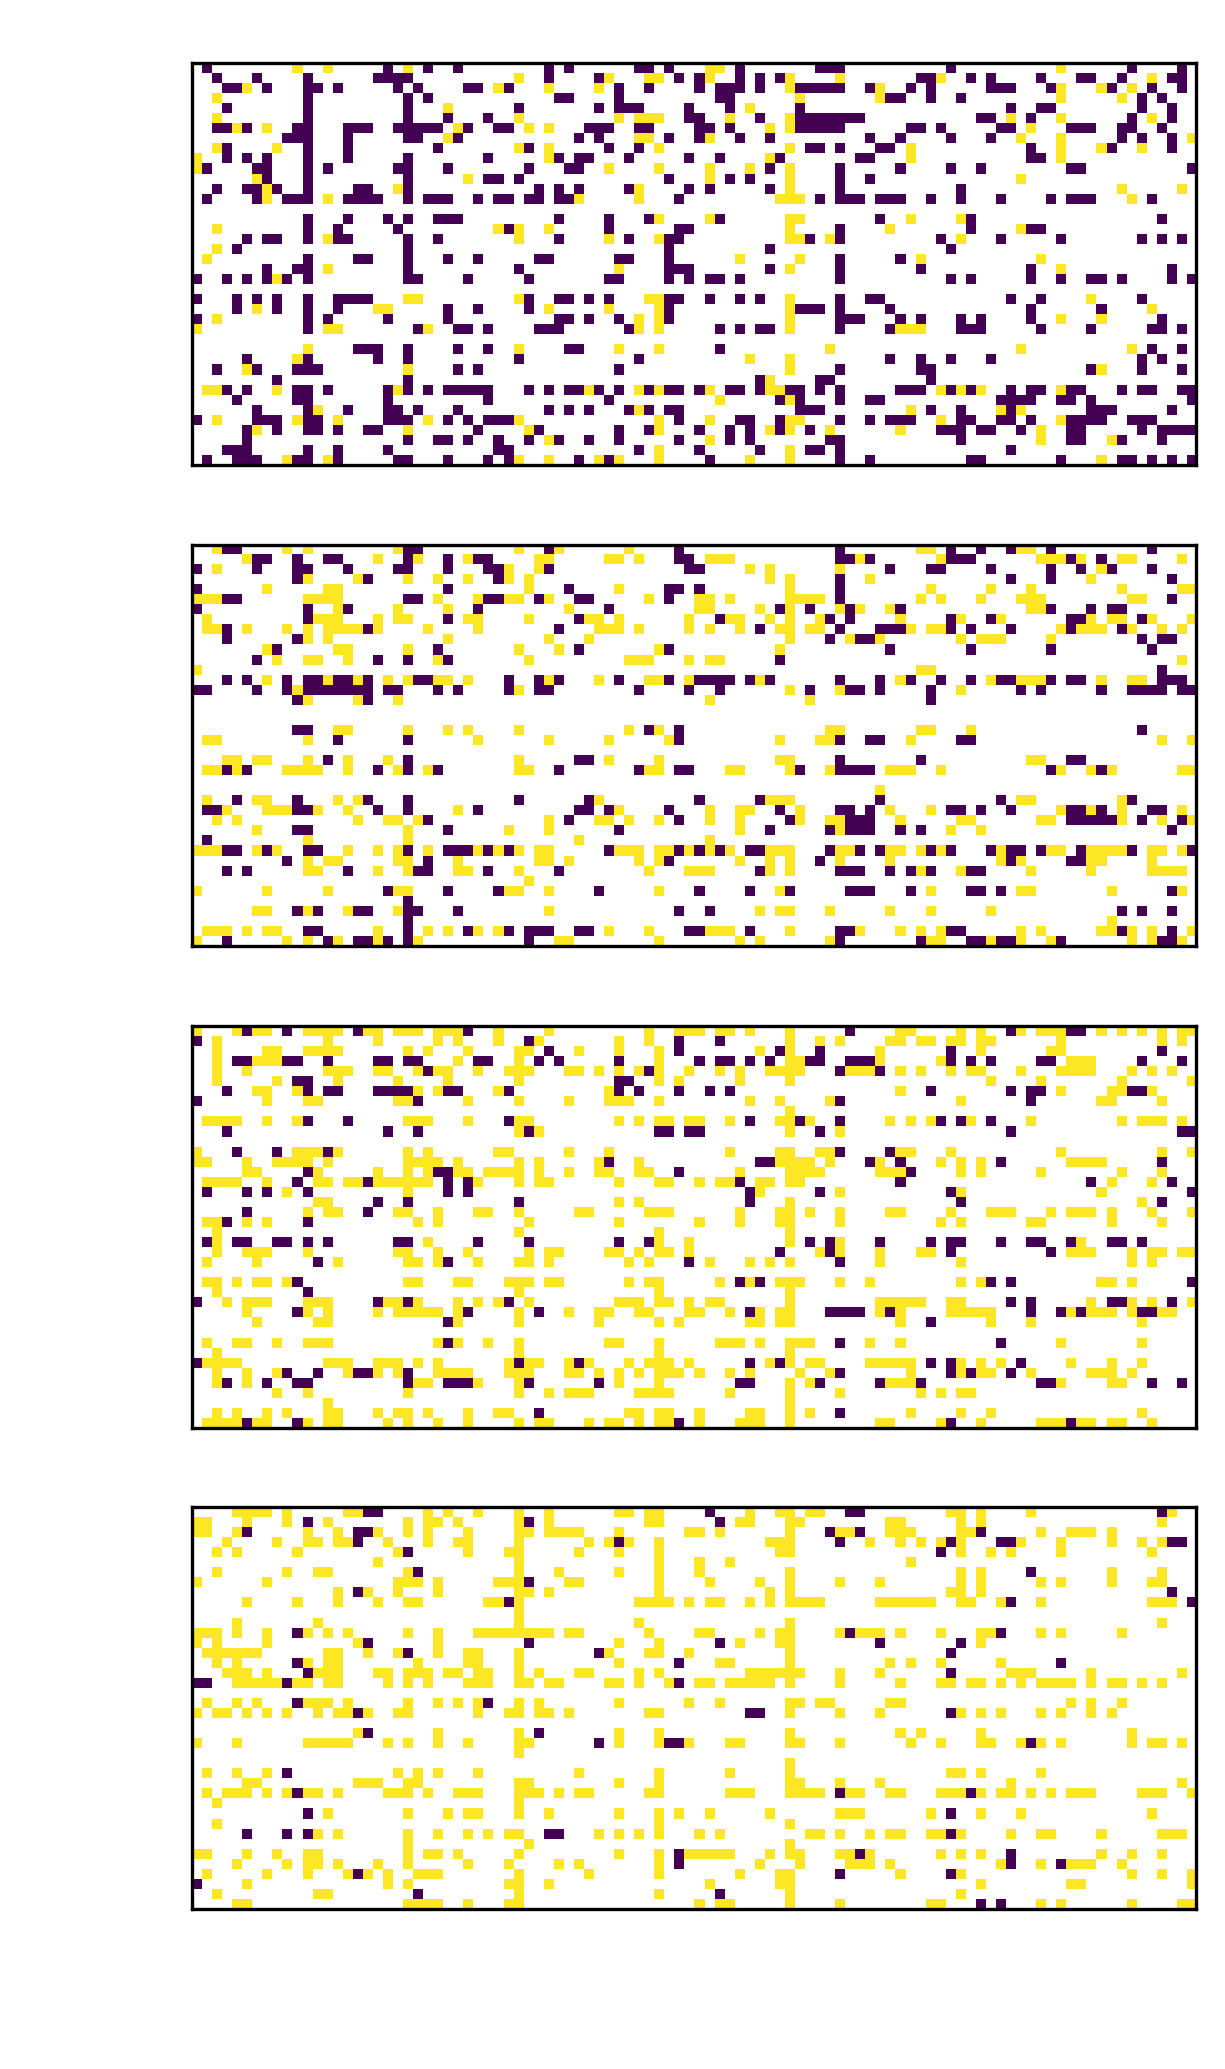

In [197]:
mice = params['Mouse_ID'].unique()
print(mice)
mice = ['E4.5', 'E5.5', 'E6.5', 'E7.5']

print(mice)
fr, to = 0, 100
fig, ax = plt.subplots(len(mice),1, figsize=(7,7),
                       # figsize=figsize_for[direction],
                       dpi=300, sharex=True, sharey=True)
for i,mouse in enumerate(mice):
    jdx = params['Mouse_ID'].values == mouse
    xmouse = xpos[jdx,:]
    ax[i].imshow(xmouse[:,~idx_filter][:40,fr:to])

[ax[i].tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False) for i in range(len(ax))]
plt.savefig(f'PICS/png/Th15_stochastic_embryos_large_no_lasso_{direction}.png', format='png', dpi=300)
plt.show()

['E4.5', 'E5.5', 'E6.5', 'E7.5']
Categories (4, object): ['E4.5', 'E5.5', 'E6.5', 'E7.5']
['E4.5', 'E5.5', 'E6.5', 'E7.5']


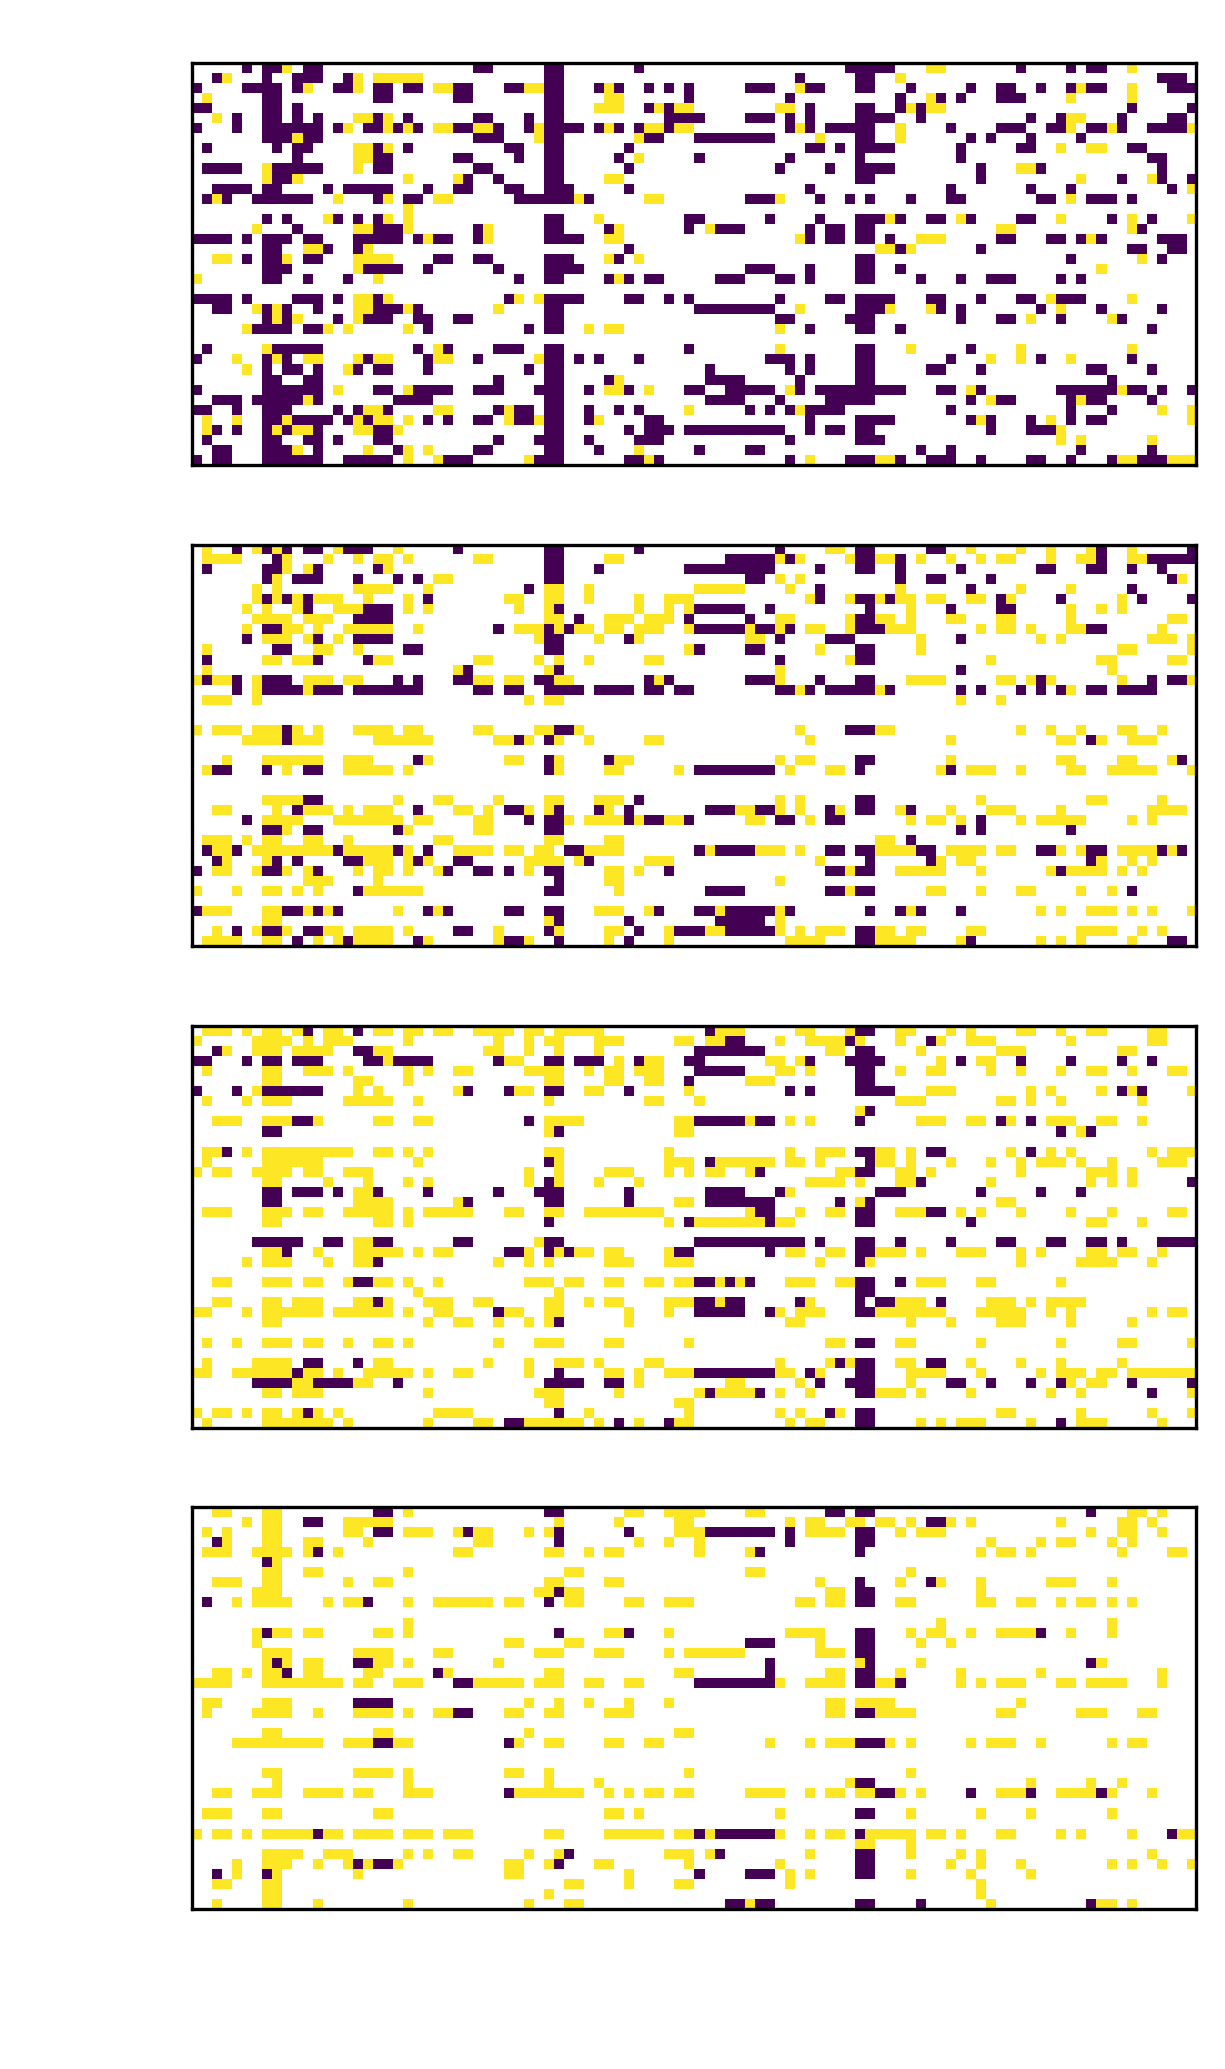

In [198]:
mice = params['Mouse_ID'].unique()
print(mice)
mice = ['E4.5', 'E5.5', 'E6.5', 'E7.5']

print(mice)
fr, to = 0, 100
fig, ax = plt.subplots(len(mice),1, figsize=(7,7),
                       # figsize=figsize_for[direction],
                       dpi=300, sharex=True, sharey=True)
for i,mouse in enumerate(mice):
    jdx = params['Mouse_ID'].values == mouse
    xmouse = xpos[jdx,:]
    ax[i].imshow(xmouse[:,idx_filter][:40,fr:to])

[ax[i].tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False) for i in range(len(ax))]
plt.savefig(f'PICS/png/Th15_coreg_embryos_large_no_lasso_{direction}.png', format='png', dpi=300)
plt.show()

In [69]:
idx_filter_cut = idx_filter.copy()
idx_filter_cut[np.roll(idx_filter,1)] = True
idx_filter_cut[np.roll(idx_filter,-1)] = True

['E4.5', 'E5.5', 'E6.5', 'E7.5']
Categories (4, object): ['E4.5', 'E5.5', 'E6.5', 'E7.5']
['E4.5', 'E5.5', 'E6.5', 'E7.5']
(50, 304)
(50, 304)
(50, 304)
(50, 304)


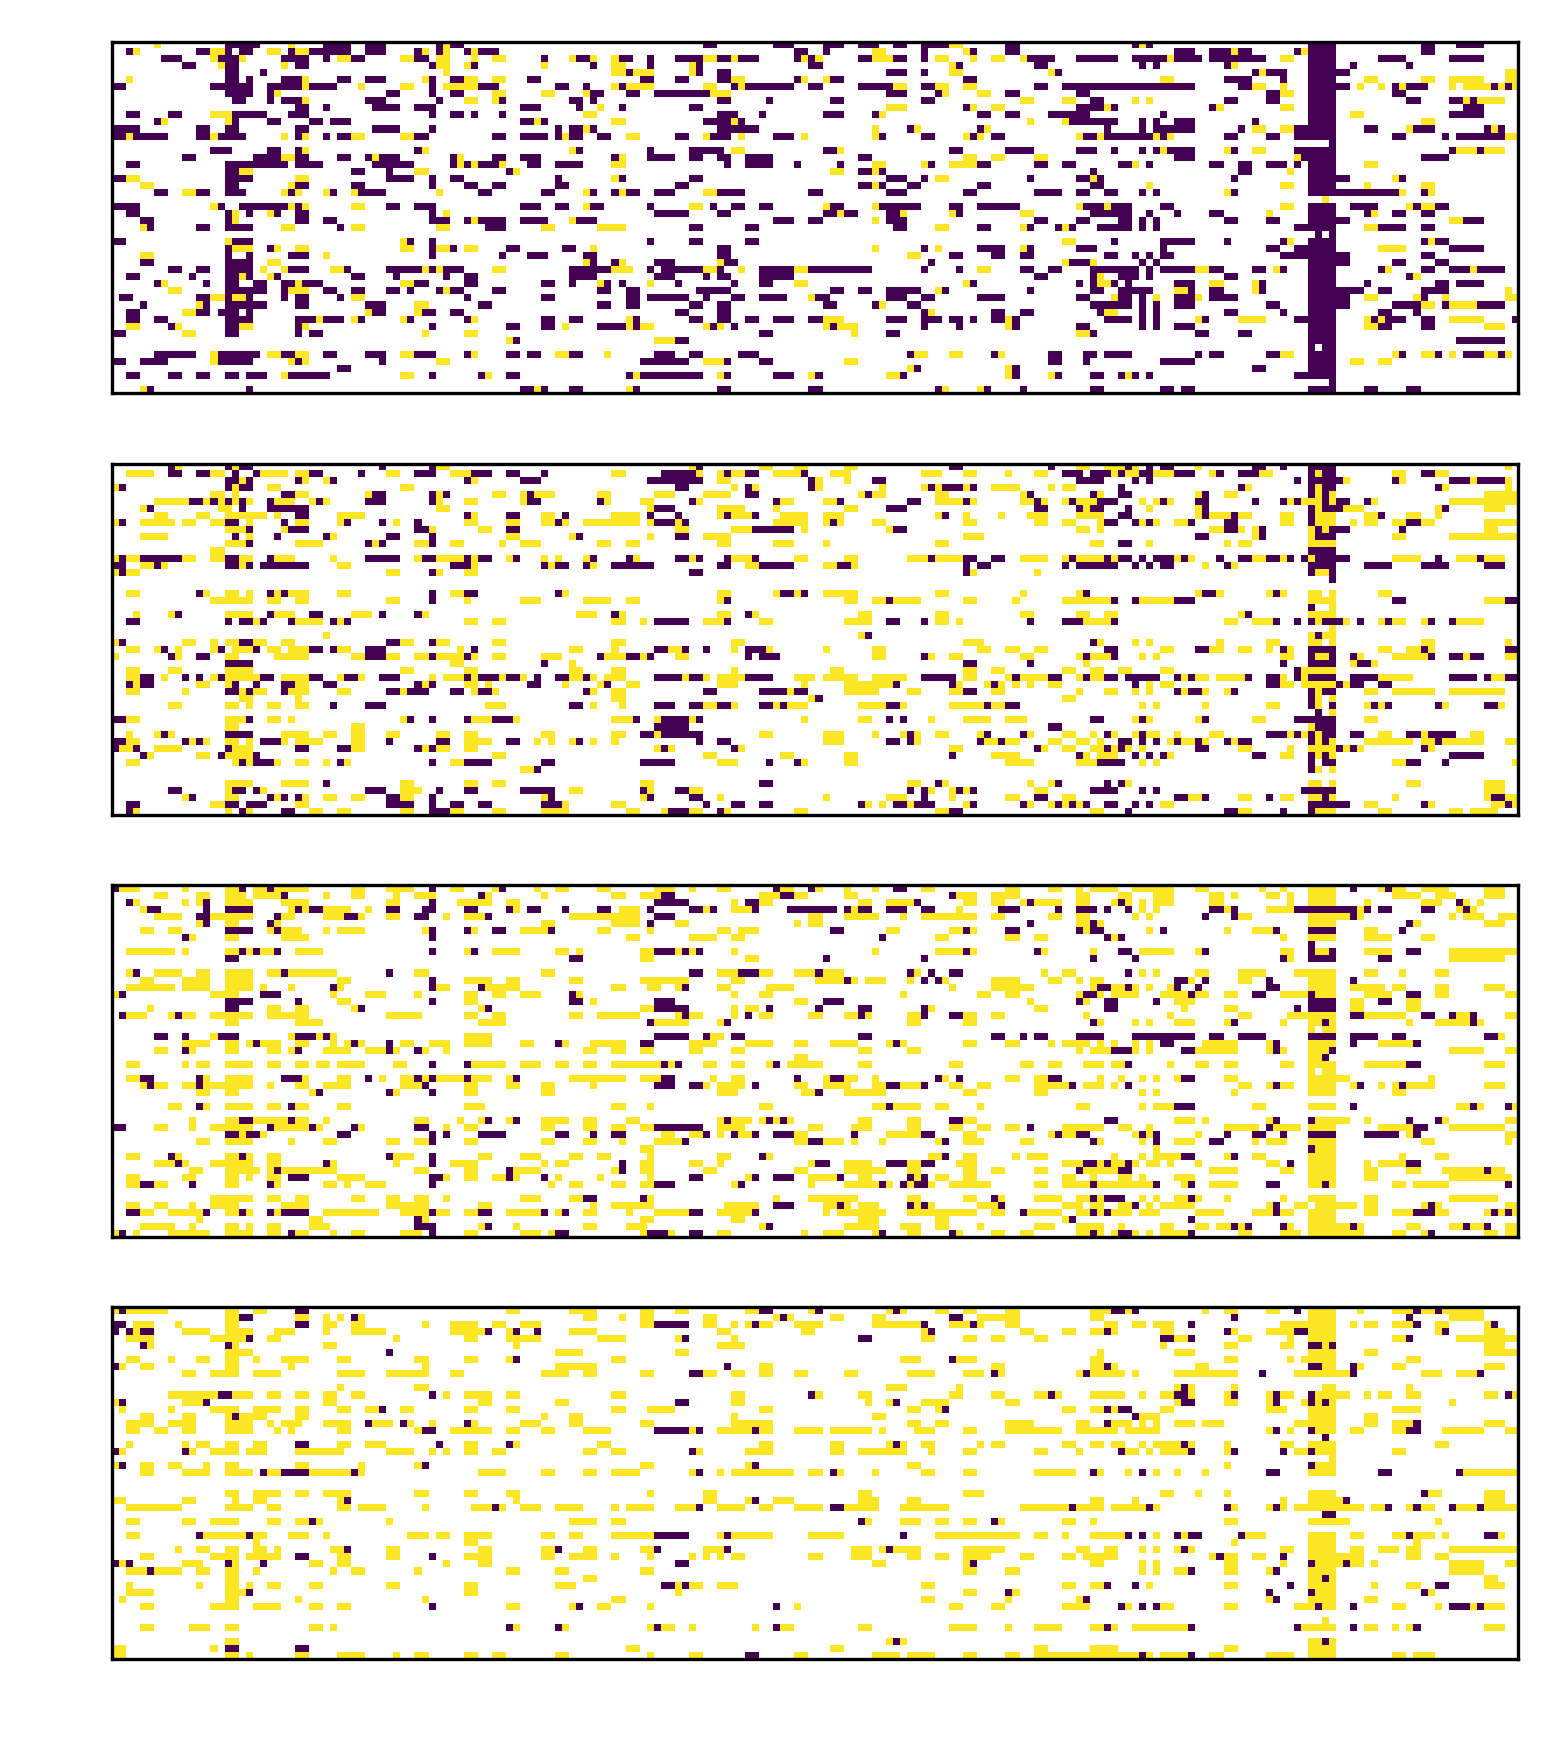

In [70]:
mice = params['Mouse_ID'].unique()
print(mice)
mice = ['E4.5', 'E5.5', 'E6.5', 'E7.5']
print(mice)
fig, ax = plt.subplots(len(mice),1,figsize=(7,7),
                       # figsize=figsize_for[direction],
                       dpi=300, sharex=True, sharey=True)
for i,mouse in enumerate(mice):
    jdx = params['Mouse_ID'].values == mouse
    xmouse = xpos[jdx,:][:50,:]
    ax[i].imshow(xmouse[:,idx_filter][:,:200])
    print(xmouse[:,idx_filter].shape)
[ax[i].tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False) for i in range(len(ax))]
plt.savefig(f'PICS/png/Th15_coreg_stochastic_cut_no_lasso_embryos_E45_{direction}.png', format='png', dpi=300)
plt.show()

In [71]:
idx_filter_stoch = np.logical_and(idx_filter_cut, ~idx_filter)
print(idx_filter_stoch.shape, np.sum(idx_filter_stoch))

(6000,) 276


['E4.5', 'E5.5', 'E6.5', 'E7.5']
Categories (4, object): ['E4.5', 'E5.5', 'E6.5', 'E7.5']
['E5.5', 'E6.5', 'E7.5']


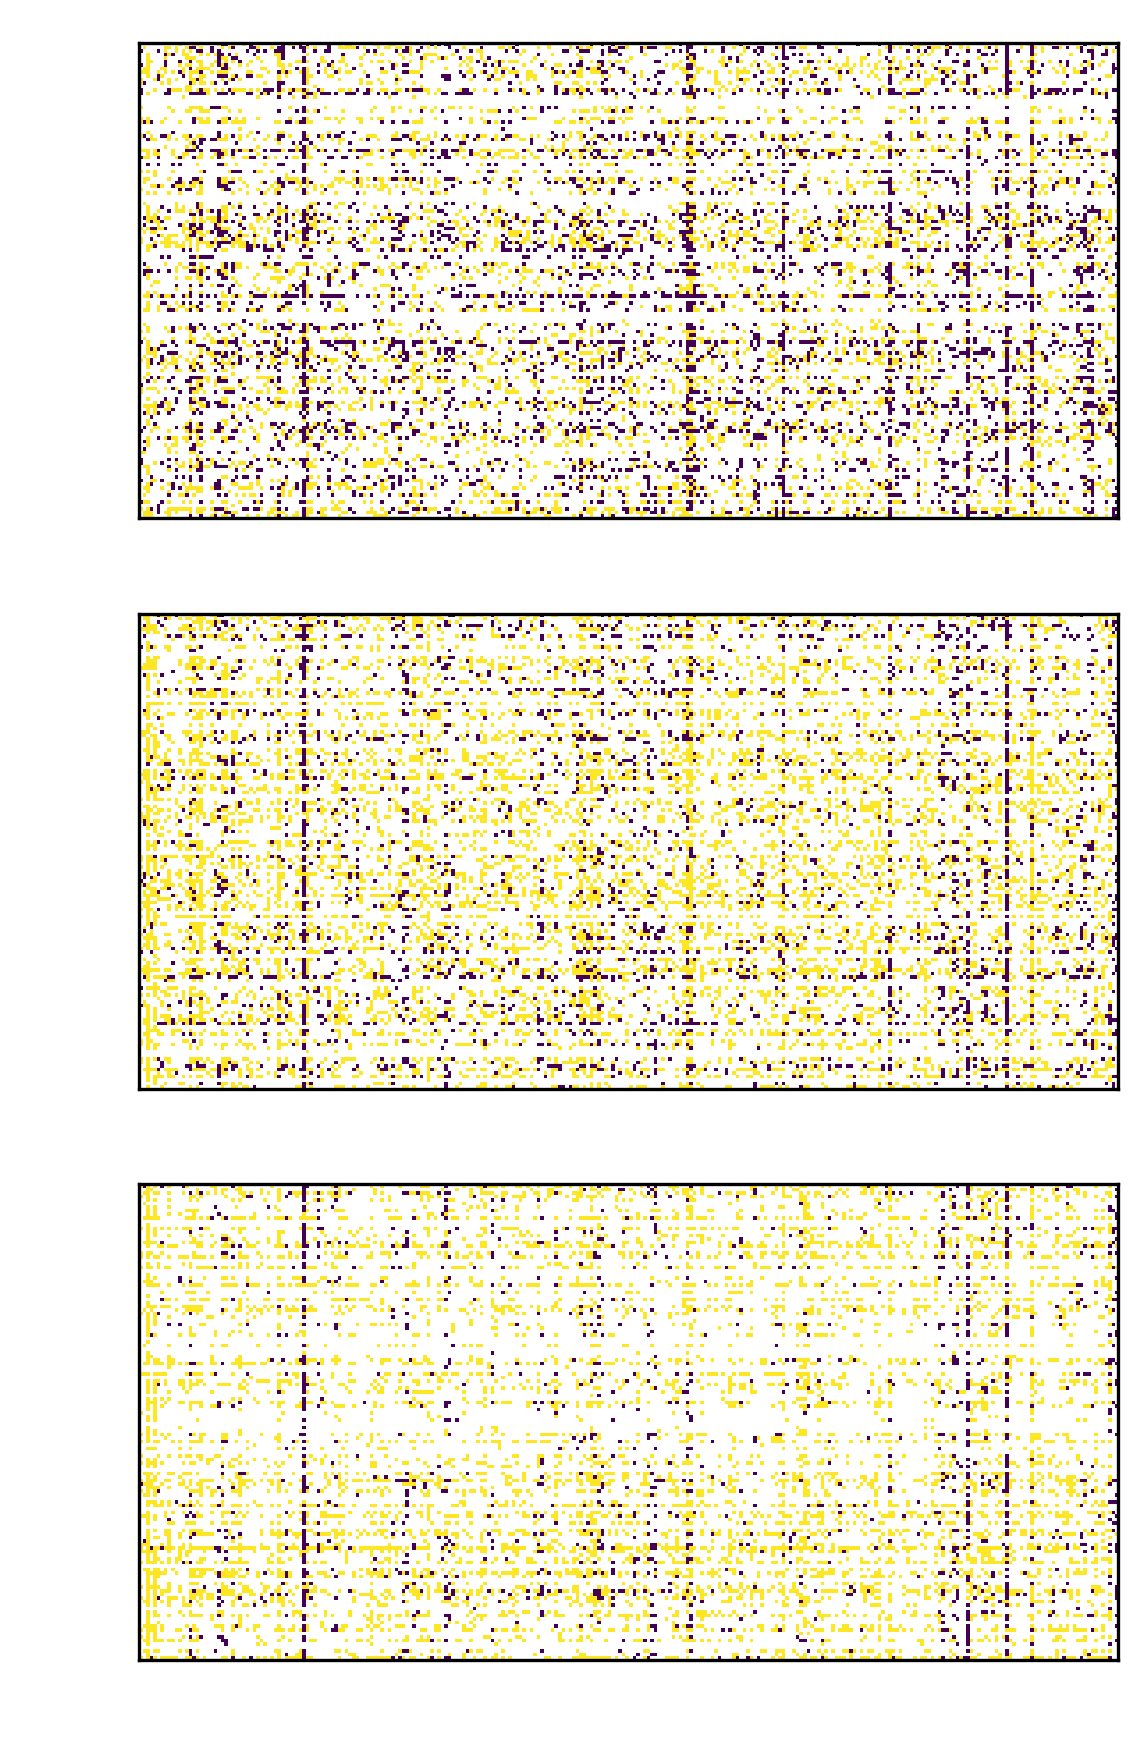

In [ ]:
mice = params['Mouse_ID'].unique()
print(mice)
mice = ['E5.5', 'E6.5', 'E7.5']
print(mice)
fig, ax = plt.subplots(len(mice),1, figsize=(7,7),
                       # figsize=figsize_for[direction],
                       dpi=300, sharex=True, sharey=True)
for i,mouse in enumerate(mice):
    jdx = params['Mouse_ID'].values == mouse
    xmouse = xpos[jdx,:][:134,:]
    ax[i].imshow(xmouse[:,idx_filter_stoch])

[ax[i].tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False) for i in range(len(ax))]
plt.savefig(f'PICS/png/Th15_stochastic_cut_embryos_{direction}.png', format='png', dpi=300)
plt.show()

['E4.5', 'E5.5', 'E6.5', 'E7.5']
Categories (4, object): ['E4.5', 'E5.5', 'E6.5', 'E7.5']
['E4.5', 'E5.5', 'E6.5', 'E7.5']


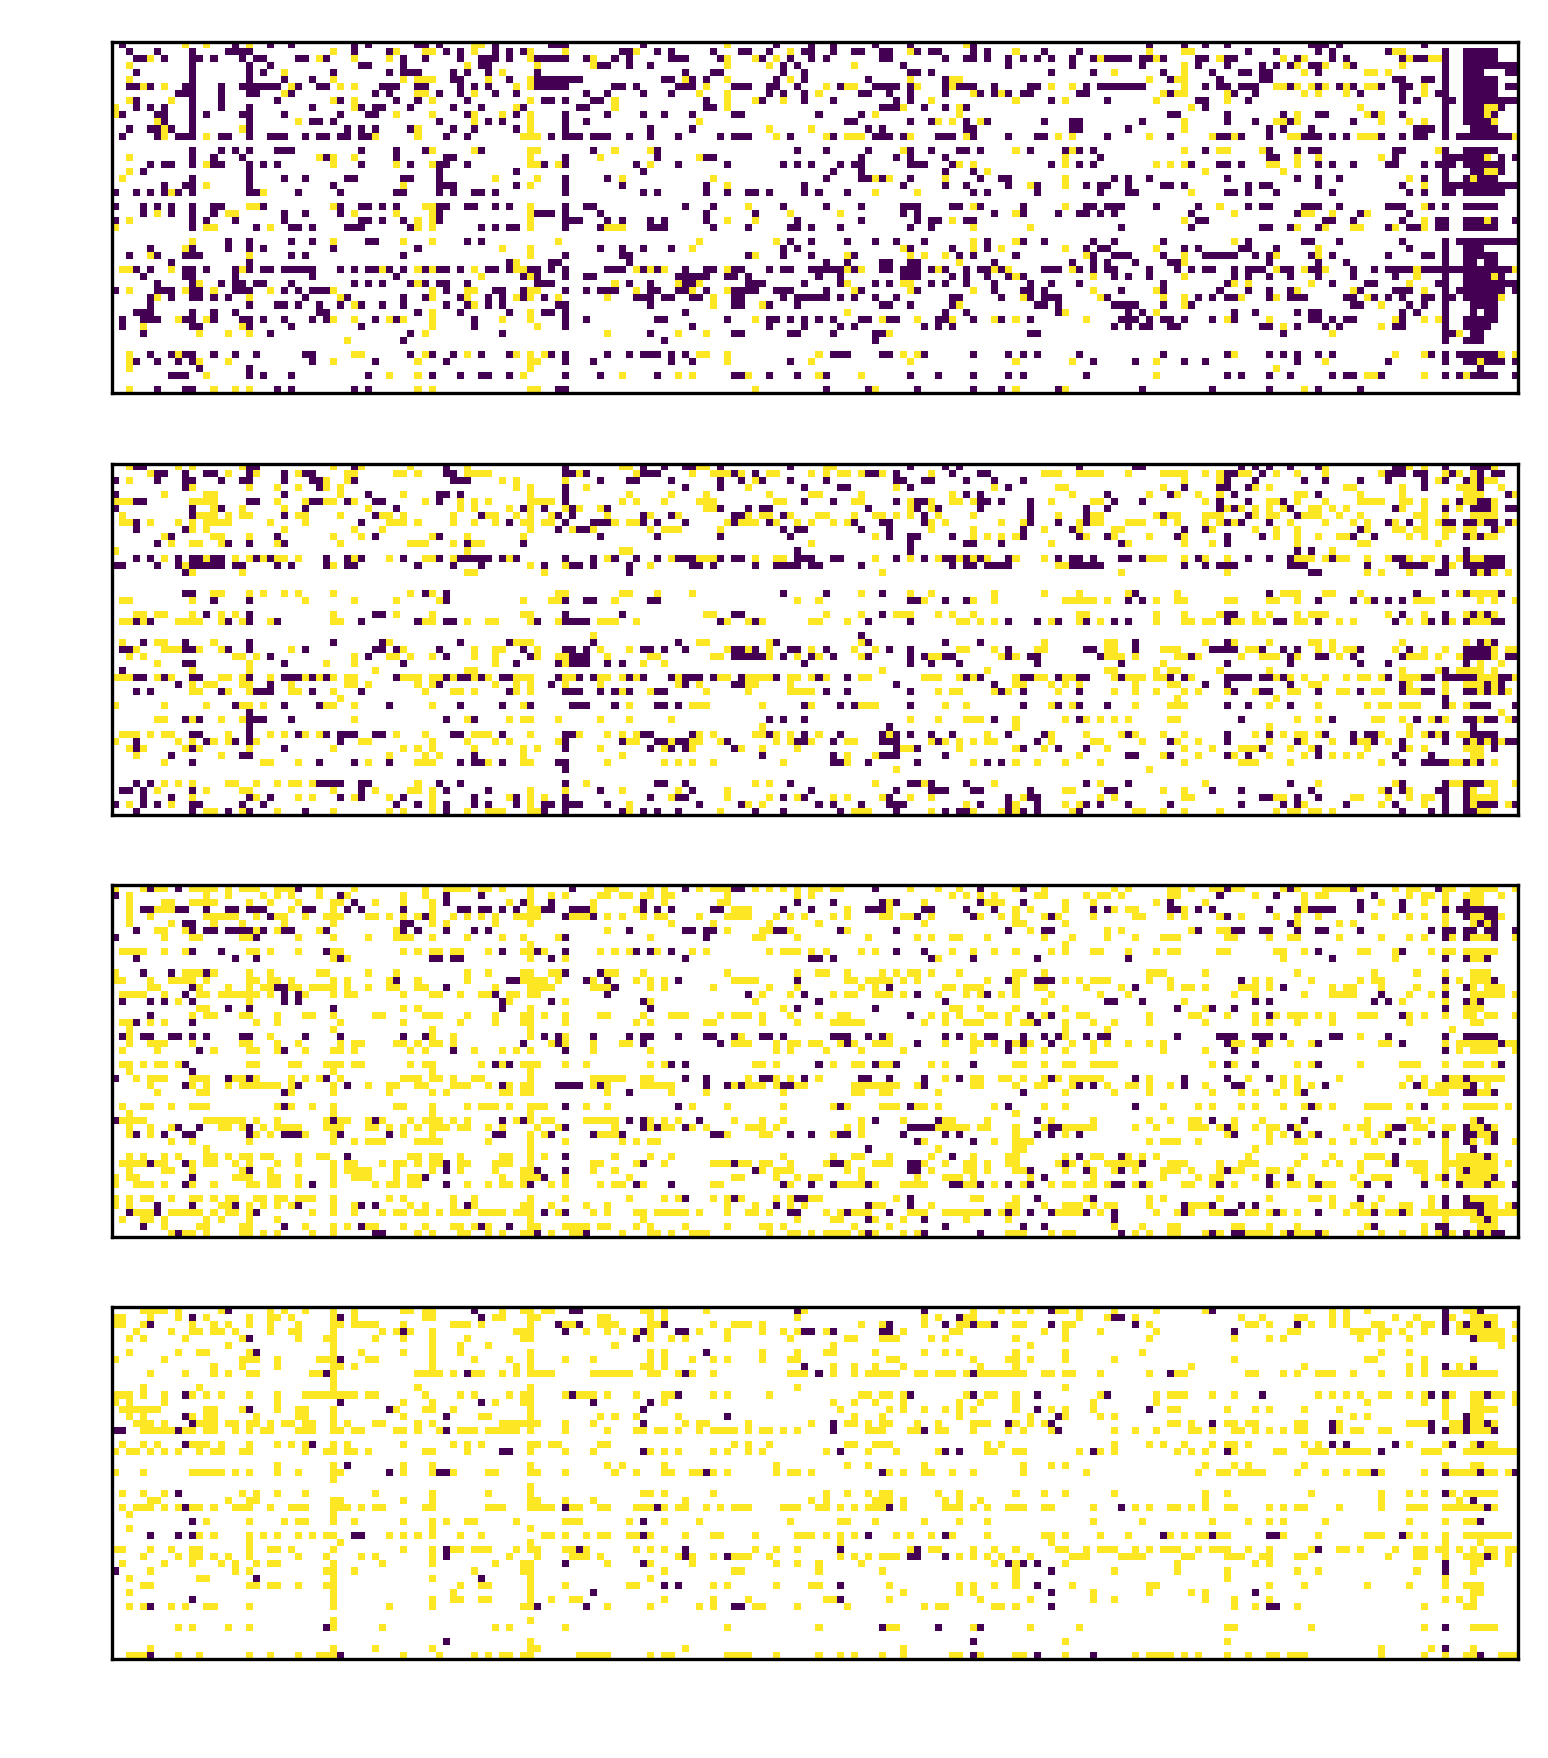

In [ ]:
mice = params['Mouse_ID'].unique()
print(mice)
mice = ['E4.5','E5.5', 'E6.5', 'E7.5']
print(mice)
fig, ax = plt.subplots(len(mice),1, figsize=(7,7),
                       # figsize=figsize_for[direction],
                       dpi=300, sharex=True, sharey=True)
for i,mouse in enumerate(mice):
    jdx = params['Mouse_ID'].values == mouse
    xmouse = xpos[jdx,:][:50,:]
    ax[i].imshow(xmouse[:,~idx_filter][:,:200])
    
[ax[i].tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False) for i in range(len(ax))]

plt.savefig(f'PICS/png/Th15_stochastic_samesizeascoreg_embryos_E45_{direction}.png', format='png', dpi=300)
plt.show()

['E5.5', 'E6.5', 'E7.5']
Categories (3, object): ['E5.5', 'E6.5', 'E7.5']
['E5.5', 'E6.5', 'E7.5']


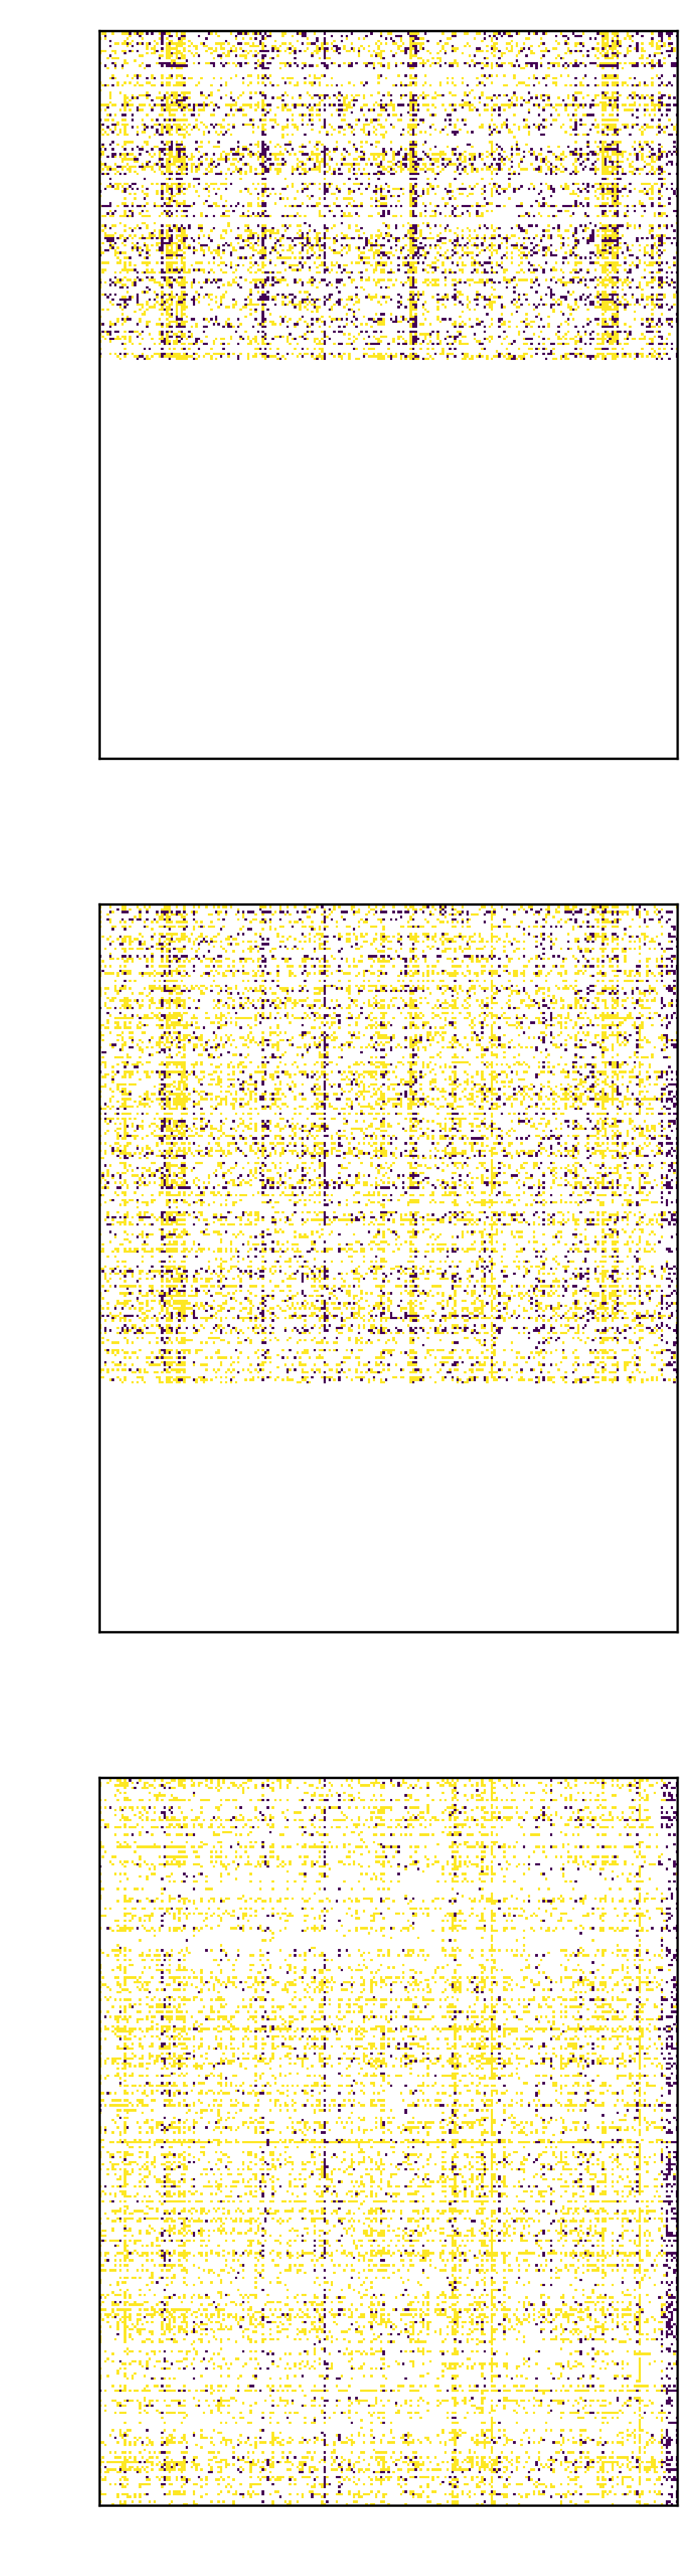

In [ ]:
mice = params['Mouse_ID'].unique()
print(mice)
mice = ['E5.5', 'E6.5', 'E7.5']
print(mice)
fig, ax = plt.subplots(len(mice),1, figsize=(7,15),
                       # figsize=figsize_for[direction],
                       dpi=300, sharex=True, sharey=True)
for i,mouse in enumerate(mice):
    jdx = params['Mouse_ID'].values == mouse
    xmouse = xpos[jdx,:]
    ax[i].imshow(xmouse[:,idx_filter_stoch])

[ax[i].tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False) for i in range(len(ax))]

plt.savefig(f'PICS/png/Th15_stochastic_cut_no_lasso_embryos_{direction}.png', format='png', dpi=300)
plt.show()